### Data
- provided by the Institute of Atmospheric Physics Kühlungsborn (IAP)
- ERA5: daily means at a pressure level of 10hPa and analysis
    - Intercomparison with Hannachi et al. (2011)
    - SWE1.tar: contains major warming diagnostics
    - SWE1.tar: elliptic diagnostics of Z10
    - SWX1.tar: extended diagnostics (reachable via VPN)
    - SWC1.tar: classfiication synthesis (reachable via VPN)

#### File structure
netCDF files are 3-dimensional data, investigated with ncdump. The .tar-files contain all output from Christoph Zülickes diagnosis, in particular:
- SWM: ASCII values in 2 files, 
    1. *cen.csv with the major warming events as identified with their central day when the wind turned from westerly to easterly along with some characteristics and
    2. *msw.csv with daily lists with wind and a marker mw for major warming
- SWE: 1 csv file
    - *d.csv: daily list of indices, including the aspect ratio of the mother vortex (ar), centrail latitude (latcent) and area (area)

In [120]:
import arctic
from arctic.io.loader import read_data
from arctic.io.cleaner import no_white_space, to_date

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# read data
era5_d = read_data("../data/SWXClust/ERA5/e5e1_d.csv")
era5_cen = read_data("../data/SWXClust/ERA5/e5m1t-cen.csv")
era5_msw = read_data("../data/SWXClust/ERA5/e5m1t-msw.csv")

# remove white space from column names
no_white_space(era5_d)
no_white_space(era5_cen)
no_white_space(era5_msw)

# change string to datetime for better comparison
to_date(era5_d, 'string', format='%d.%m.%Y-%H:%M:%S')
to_date(era5_cen, 'string', format='%d.%m.%Y-%H:%M')
to_date(era5_msw, 'string', format='%d.%m.%Y-%H:%M')

# convert columns to numeric
col_convert = [
    'area1', 'obj_area1', 'latcent1', 'loncent1', 'theta1', 'ar1',
    'area2', 'obj_area2', 'latcent2', 'loncent2', 'theta2', 'ar2'
]
era5_d[col_convert] = era5_d[col_convert].apply(pd.to_numeric, errors='coerce')
era5_d = era5_d.fillna(0)

# merge era5 data to one big dataframe
era5_all = era5_d.merge(era5_msw, on ='string', how='left', suffixes=[None, '_msw']).\
    merge(era5_cen, on='string', how='left', suffixes = ['_d', '_cen'])

# handling string encodings
# encode MW as MW = 1, else 0
from sklearn.preprocessing import LabelEncoder
le_mw = LabelEncoder()
era5_all['MW'] = le_mw.fit_transform(era5_all.MW)
print(f"Transformed 'MW':\n{le_mw.inverse_transform([1])} to 1\n{le_mw.inverse_transform([0])} to 0")
le_form = LabelEncoder()
era5_all['form'] = le_form.fit_transform(era5_all.form)
print(f"Transformed 'form': \n {le_form.inverse_transform([1])} to 1\n{le_form.inverse_transform([0])} to 0")

# handling NaN values and string encodings
era5_all[era5_cen.columns[-4:]] = era5_all[era5_cen.columns[-4:]].fillna(0)

# drop constant columns
era5_all.drop(['D_d', 'level', 'hour',
               'D_cen', 'num', 'counter_cen', 'time_cen',
               'D_msw', 'counter_msw', 'time_msw'
               ], axis=1, inplace=True)
# sort by date
era5_all = era5_all.sort_values('string').reset_index(drop=True)

# check
era5_all.info()

Transformed 'MW':
['MW'] to 1
[''] to 0
Transformed 'form': 
 ['S'] to 1
['D'] to 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21914 entries, 0 to 21913
Data columns (total 38 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   counter_d  21914 non-null  int64         
 1   time_d     21914 non-null  float64       
 2   string     21914 non-null  datetime64[ns]
 3   year       21914 non-null  int64         
 4   month      21914 non-null  int64         
 5   day        21914 non-null  int64         
 6   edge       21914 non-null  float64       
 7   form       21914 non-null  int64         
 8   area       21914 non-null  float64       
 9   obj_area   21914 non-null  float64       
 10  latcent    21914 non-null  float64       
 11  loncent    21914 non-null  float64       
 12  theta      21914 non-null  float64       
 13  ar         21914 non-null  float64       
 14  kurtosis   21914 non-null  float64       
 15  are

## Reconstruction of same conditions as Hannachi et al. 2011
- time: winterperiod (december to march) from 1958 to 2002, activity peaks in dec - jan, oscilliation period around 120-130d
    - **Note**: only data after 1963 available 
- 7 stratospheeric variables:

| temp. (lat1) | temp (lat2) |temp. (lat3) | avg. zon. wind (lat1) | avg. zon. wind (lat2) | wave-1                    | wave-2                    |
|--------------|-------------|------------------|-----------------------|-----------------------|---------------------------|---------------------------|
| Zonally averaged | Zonally averaged | Zonally averaged | Zonally averaged <br/ | Zonally averaged      | Normalised by zonal winds | Normalised by zonal winds |
| 60-70°N      | 70-80°N     | 80-90°N          | 60-70°N               | 70-80°N               | 60°N                      | 60°N                      |

- 7 pressure levels between 100 to 1hPa
- focus on geometrical features: latitude centroid (lat), area (area), aspect ratio (AR) - kurtosis omitted due to skewness

### Approaches
#### Scaling
It is not explicitly mentioned which methods were used for scaling. A look at the timeseries diagrams suggest a StandardScaler (i.e. a mean of 0 and variance of 1)

#### Seasonality
Single Spectrum Analysis (SSA) to deal with seasonality and signal propagation in polar vortex area. The technique has to be applied to the entire dataset. And is implemented in the next code cells.

#### Gap statistic
The gap statistic is used to find the number of clusters by comparing the model to a homogeneous Poisson point process-

#### Hierarchical Clustering
- Used distance: Euclidean distance
- Distance between Cluster: Complete Linkage to avoid chain and spheroidal tendencies of single and average linkage

|               | between points in Cluster | to different clusters                      |
|---------------|---------------------------|--------------------------------------------|
| Closest       | Single Linkage            | Centroid Linkage                           |
| Most Distance | **Complete Linkage**      | Average Linkage (Average of all distances) |


### Time series of scaled AR, Latcent, Area and kurtosis
Due to data difference the first 1000 days could not be displayed as in Hannachi et al. There is a difference of 516 days (i.e. day 484 in the diagram below corresponds to day 1000 in Figure 2 from Hannachi et al.). This is illustrated by the dotted line in the diagram.

Further it is unclear in which order the following steps where performed: scaling, selection of DJFM period.
Scaling first, then selecting DJFM does result in a different scaling as doing vice versa.
Form the resulting diagrams, it appears to be that the time period is first selected and then scaled. When first scaling, then selecting, the "baseline" of kurtosis seems to be slightl below 0.

In [125]:
from sklearn.preprocessing import StandardScaler

# scale entire data
sc = StandardScaler()
era5_all = era5_all[era5_all['string'] < '02-05-2006'] # buffer for filtering with eeof: 400days
era5_all.loc[:,['scaled_area', 'scaled_ar', 'scaled_latcent', 'scaled_kurtosis']] = sc.fit_transform(era5_all[['area', 'ar', 'latcent', 'kurtosis']])

# time constraints
era5_winter = era5_all[(era5_all['string'] < '03-15-2006') &
                     (era5_all['month']).isin([12,1,2,3])]
era5_winter.reset_index(drop=True, inplace=True)

# only geometric moments
era5_hannachi = era5_winter[['string', 'year', 'month', 'day', 'area', 'ar', 'latcent', 'kurtosis']]
# scale DJFM
era5_hannachi.loc[:, ['scaled_area', 'scaled_ar', 'scaled_latcent', 'scaled_kurtosis']] = sc.fit_transform(era5_hannachi[['area', 'ar', 'latcent', 'kurtosis']])

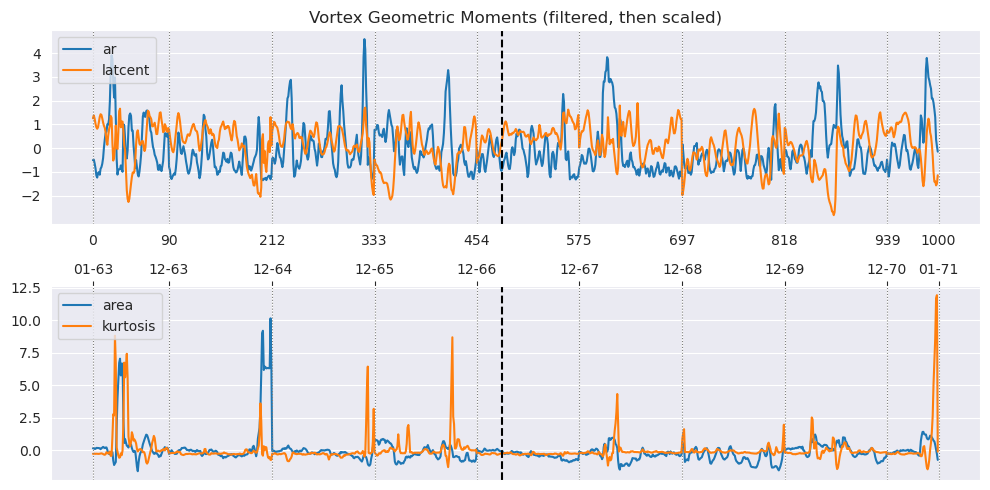

In [146]:
# plot timeseries on DJFM
fig, ax = plt.subplots(2, figsize=(10, 5))
ax[0].set_title('Vortex Geometric Moments (filtered, then scaled)')

ax[0].plot(era5_hannachi['scaled_ar'][:1000], label='ar')
ax[0].plot(era5_hannachi['scaled_latcent'][:1000], label='latcent')
ax[0].axvline(x=484, color='black', linestyle='--')
ax[0].legend(loc='upper left')

ax[1].plot(era5_hannachi['scaled_area'][:1000], label='area')
ax[1].plot(era5_hannachi['scaled_kurtosis'][:1000], label='kurtosis')
ax[1].axvline(x=484, color='black', linestyle='--')
ax[1].legend(loc='upper left')

positions = [0]
positions[1: ] = [x for x in range(90, 1000, 121)]
positions[2:] = list(map(lambda x: x+1 , positions[2:]))
positions[6:] = list(map(lambda x: x+1 , positions[6:]))
positions.append(1000)

# Add grey vertical lines every 120 days
for x in positions:
    ax[0].axvline(x=x, color='grey', linestyle=':', linewidth=0.8)
    ax[1].axvline(x=x, color='grey', linestyle=':', linewidth=0.8)

labels = era5_hannachi.iloc[positions, :]['string']
formatted_labels = labels.dt.strftime('%m-%y')

ax[0].set_yticks([i for i in range(-2, 5)])
ax[0].set_xticks(positions)
ax[1].set_xticks(positions)
ax[1].set_xticklabels(formatted_labels, ha='center')
ax[1].xaxis.tick_top()
ax[1].xaxis.set_label_position('top')
plt.tight_layout()
plt.savefig('../output/data.png')
plt.show()

# convenience purpose only: uncomment below to see pot of entire time series that was first scaled and then reduced to DJFM
# # plot timeseries on entire year
# fig, ax = plt.subplots(2, figsize=(10, 5))
# ax[0].set_title('Vortex Geometric Moments (scaled, then filtered)')
#
# ax[0].plot(era5_winter['scaled_ar'][:1000], label='ar')
# ax[0].plot(era5_winter['scaled_latcent'][:1000], label='latcent')
# ax[0].axvline(x=484, color='black', linestyle='--')
# ax[0].legend(loc='upper left')
#
# ax[1].plot(era5_winter['scaled_area'][:1000], label='area')
# ax[1].plot(era5_winter['scaled_kurtosis'][:1000], label='kurtosis')
# ax[1].axvline(x=484, color='black', linestyle='--')
# ax[1].legend(loc='upper left')
#
# positions = [0]
# positions[1: ] = [x for x in range(90, 1000, 121)]
# positions[2:] = list(map(lambda x: x+1 , positions[2:]))
# positions[6:] = list(map(lambda x: x+1 , positions[6:]))
# positions.append(1000)
#
# # Add grey vertical lines every 120 days
# for x in positions:
#     ax[0].axvline(x=x, color='grey', linestyle=':', linewidth=0.8)
#     ax[1].axvline(x=x, color='grey', linestyle=':', linewidth=0.8)
#
# # positions = [i for i in range(0, 1000, 60)]
#
# labels = era5_winter.iloc[positions, :]['string']
# formatted_labels = labels.dt.strftime('%m-%y')
#
# ax[0].set_yticks([i for i in range(-2, 6)])
# ax[0].set_xticks(positions)
# ax[1].set_xticks(positions)
# ax[1].set_xticklabels(formatted_labels, ha='center')
# ax[1].xaxis.tick_top()
# ax[1].xaxis.set_label_position('top')
# plt.tight_layout()

## Durbin-Watson Test
Assumptions: The errors are normally distributed, and the mean is 0. The errors are stationary.
Range: 0 to 4
Interpretation:
- 0 to 1.5 indicating positive autocorrlation
- 1.5 to 2.5: no or weak autocorrelation
- 2.5 to 4: indicating negative autocorrelation

The Durbin-Watson Test does indicates a strong autocorrelation, as found by Hannachi et al. (2011).

In [128]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(era5_hannachi['scaled_area'])
print(f"Durbin-Watson statistic on DJFM, then scaled area: {dw}")

dw_winter = durbin_watson(era5_winter['scaled_area'])
print(f"Durbin-Watson statistic on scaled, then DJFM area: {dw_winter}")

dw_all = durbin_watson(era5_all['scaled_area'])
print(f"Durbin-Watson statistic on all data: {dw_all}")

Durbin-Watson statistic on DJFM, then scaled area: 0.2554799337089991
Durbin-Watson statistic on scaled, then DJFM area: 0.04011854626901786
Durbin-Watson statistic on all data: 0.27488039815296184


## Autocorrelation function
The dashed lines show the boundary of 5% significant autocorrelation.

Scaling has no influence on the autocorrelation.

Autocorrelation is computed with

$$\rho_k = \frac{Cov(x_t, x_{t-k})}{\sigma(x_t) \sigma(x_{t-k})}$$

on unit vector normalised data. The scaling has no significant influence on the autocorrelation.

Takes very long for large lags. Works best between 500 and 1500.

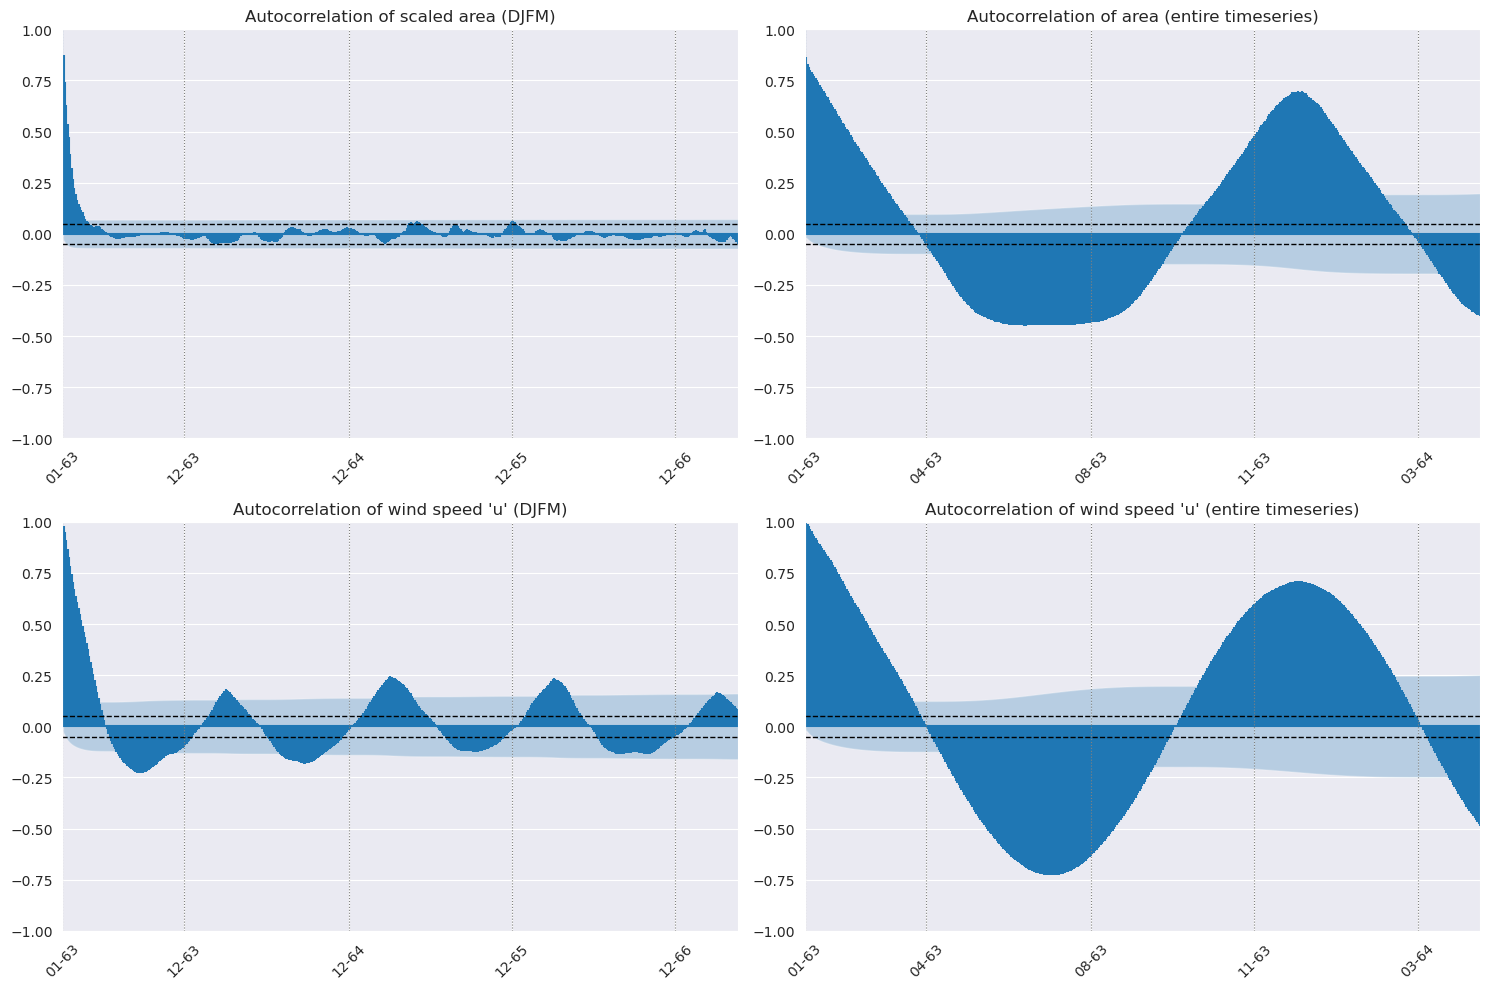

In [162]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(2,2, figsize=(15, 10))
ax = ax.flatten()
plot_acf(era5_hannachi['area'], lags=500, ax=ax[0],  marker=None)
plot_acf(era5_all['area'], lags=500, ax=ax[1], marker=None)
ax[1].plot(era5_all['string'][:500], np.zeros_like(era5_all[:500]), alpha=0)
plot_acf(era5_winter['u'], lags=500, ax=ax[2], marker=None)
plot_acf(era5_all['u'], lags=500, ax=ax[3], marker = None)

ax[0].set_title('Autocorrelation of scaled area (DJFM)')
ax[1].set_title('Autocorrelation of area (entire timeseries)')
ax[2].set_title("Autocorrelation of wind speed 'u' (DJFM)")
ax[3].set_title("Autocorrelation of wind speed 'u' (entire timeseries)")

for i in range(4):
    ax[i].axhline(y=0.05, linestyle='--', color='black', linewidth=1)
    ax[i].axhline(y=-0.05, linestyle='--', color='black', linewidth=1)
    ax[i].set_xlim(0, 500)
    ax[i].set_xticks(positions[:5])
    for x in positions:
        if x < 500:
            ax[i].axvline(x=x, color='grey', linestyle=':', linewidth=0.8)

    if i%2==0:
        ax[i].set_xticklabels(formatted_labels[:5], ha='center', rotation=45)
    else:
        ax[i].set_xticklabels(formatted_all[:5], ha='center', rotation=45)
plt.tight_layout()
plt.savefig('../output/acf.png')
plt.show()

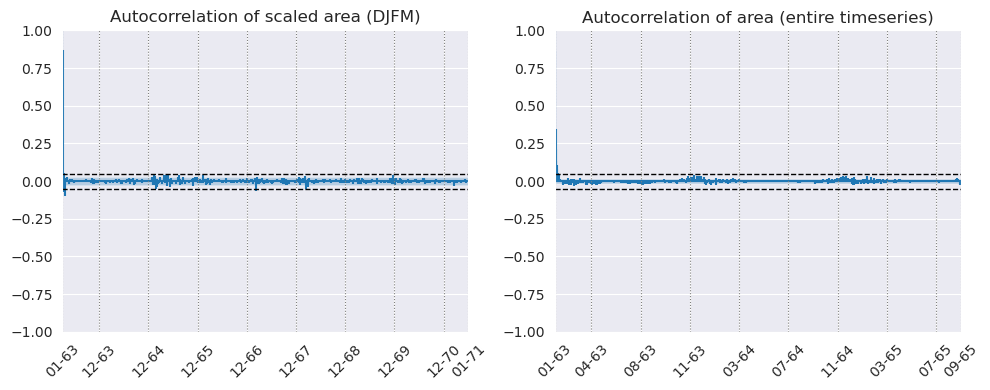

In [107]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
plot_pacf(era5_hannachi['scaled_area'], lags=1000, ax=ax[0], label='ACF filtered, then scaled area)', marker=None)
plot_pacf(era5_all['scaled_area'], lags=1000, ax=ax[1], label='ACF area (entire timeseries)', marker=None)
ax[1].plot(era5_all['string'][:1000], np.zeros_like(era5_all[:1000]), alpha=0)

ax[0].set_title('Autocorrelation of scaled area (DJFM)')
ax[1].set_title('Autocorrelation of area (entire timeseries)')

for i in range(2):
    ax[i].axhline(y=0.05, linestyle='--', color='black', linewidth=1)
    ax[i].axhline(y=-0.05, linestyle='--', color='black', linewidth=1)
    ax[i].set_xlim(0, 1000)
    ax[i].set_xticks(positions)
    for x in positions:
        ax[i].axvline(x=x, color='grey', linestyle=':', linewidth=0.8)

ax[0].set_xticklabels(formatted_labels, ha='center', rotation=45)
ax[1].set_xticklabels(formatted_all, ha='center', rotation=45)
plt.tight_layout()
plt.show()

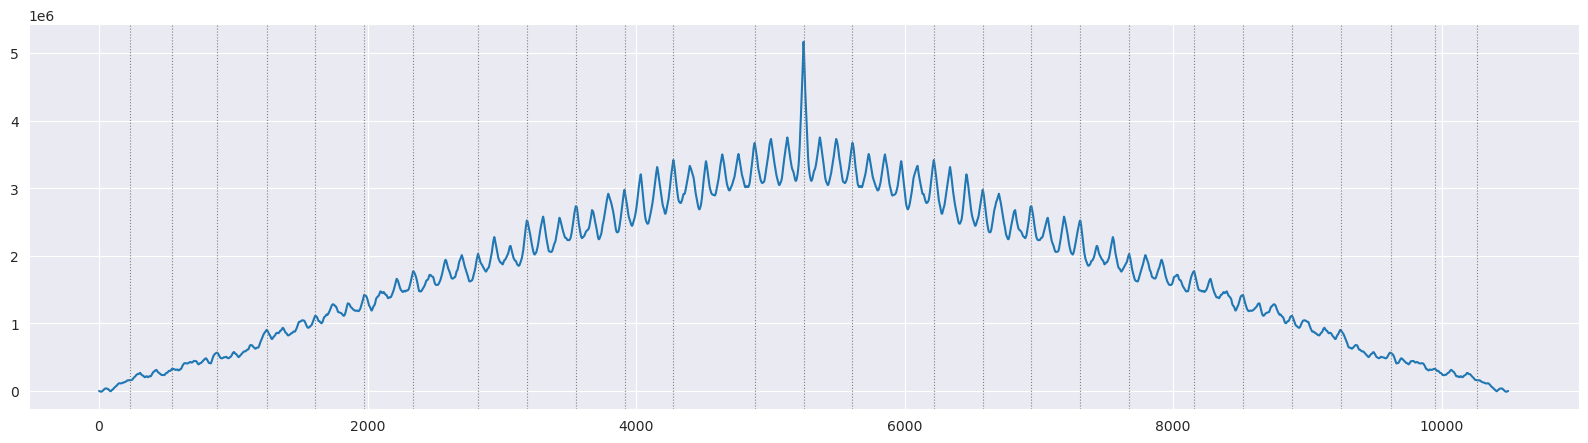

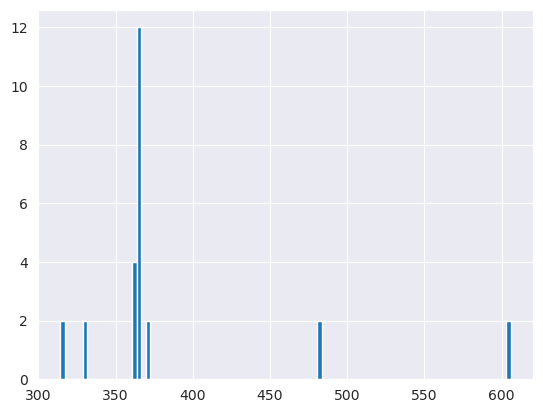

In [101]:
import scipy
corr = scipy.signal.correlate(era5_winter['u'], era5_winter['u'])
peaks, _ = scipy.signal.find_peaks(corr, distance=300)

plt.figure(figsize=(20, 5))
plt.plot(corr)
for x in peaks:
    plt.axvline(x=x, color='grey', linestyle=':', linewidth=0.8)
plt.show()
plt.hist(np.diff(peaks), bins=100)
plt.show()

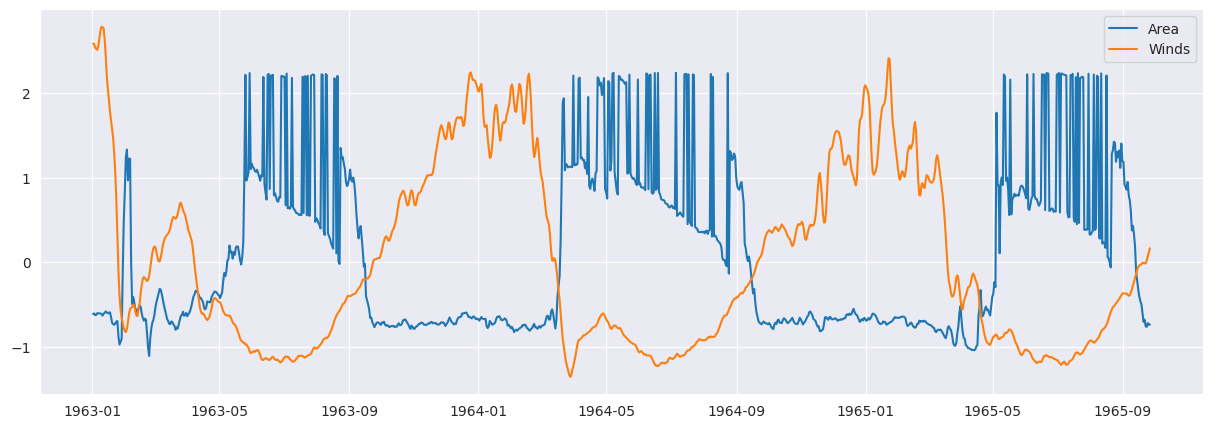

In [99]:
plt.figure(figsize=(15,5))
scaled_u = (era5_all['u']-era5_all['u'].mean())/(era5_all['u'].std())
plt.plot(era5_all['string'][:1000], era5_all[['scaled_area']][:1000], label='Area')
plt.plot(era5_all['string'][:1000], scaled_u[:1000], label='Winds')
plt.legend()
# plt.xticks(era5_all['string'][:1000], rotation=90)
plt.show()

### Filtering AREA
Hannachi et al. filtered the seasonal cycle from AREA by substracting the reconstruced signal from 4 components.

#### EEOF
Reconstructed as in their paper

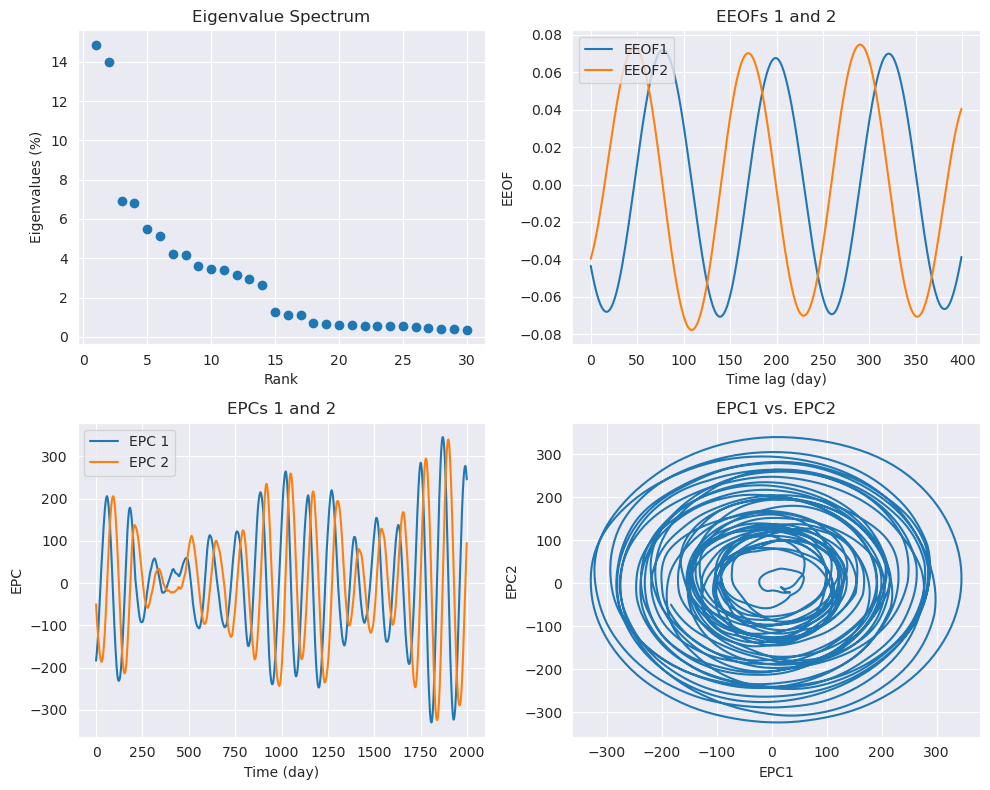

In [116]:
# to check: all data or winter data?
epc, eeof, eigenvalues, reconstructed_all, _ = arctic.compute_eeof(era5_winter['u'], M=400, n_components=30)
_, _, _, reconstructed_hannachi, _ = arctic.compute_eeof(era5_hannachi['scaled_area'], M=400, n_components=30)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0][0].scatter(np.arange(1, len(eigenvalues)+1), eigenvalues*100)
ax[0][0].set_ylabel('Eigenvalues (%)')
ax[0][0].set_xlabel('Rank')
ax[0][0].set_title('Eigenvalue Spectrum')

ax[1][1].plot(epc[:, 0], epc[:, 1])
ax[1][1].set_xlabel('EPC1')
ax[1][1].set_ylabel('EPC2')
ax[1][1].set_title('EPC1 vs. EPC2')

# ax[0].plot(era5_all['scaled_area'][:2000], label='Data')
ax[0][1].plot(eeof[0, :400], label='EEOF1')
ax[0][1].plot(eeof[1, :400], label='EEOF2')
ax[0][1].set_xlabel('Time lag (day)')
ax[0][1].set_ylabel('EEOF')
ax[0][1].set_title("EEOFs 1 and 2")
ax[0][1].legend(loc='upper left')

ax[1][0].plot(epc[:2000, 0], label='EPC 1')
ax[1][0].plot(epc[:2000, 1], label='EPC 2')
ax[1][0].set_xlabel('Time (day)')
ax[1][0].set_ylabel('EPC')
ax[1][0].set_title("EPCs 1 and 2")
ax[1][0].legend(loc = 'upper left')
plt.tight_layout()
plt.savefig('../output/eeof_era5.png')
plt.show()

#### SSA
Comparison with SSA method

In [7]:
from pyts.decomposition import SingularSpectrumAnalysis
from arctic.workflows.demo import plot_ssa_grid

ssa = SingularSpectrumAnalysis(window_size=120)
ssa_area_all = ssa.fit_transform(era5_all['scaled_area'].values.reshape(1, -1))
ssa_area_hannachi = ssa.fit_transform(era5_hannachi['scaled_area'].values.reshape(1, -1))

era5_hannachi = era5_hannachi[era5_hannachi['string'] < '01-01-2003']

In [8]:
era5_hannachi.loc[:, 'filtered_area_eeof'] = (era5_hannachi.loc[:,'scaled_area'] - reconstructed_hannachi[399:, 0])
era5_hannachi.loc[:, 'filtered_area_ssa'] = (era5_hannachi.loc[:, 'scaled_area'] - ssa_area_hannachi[:4, :4850].sum(axis=0))

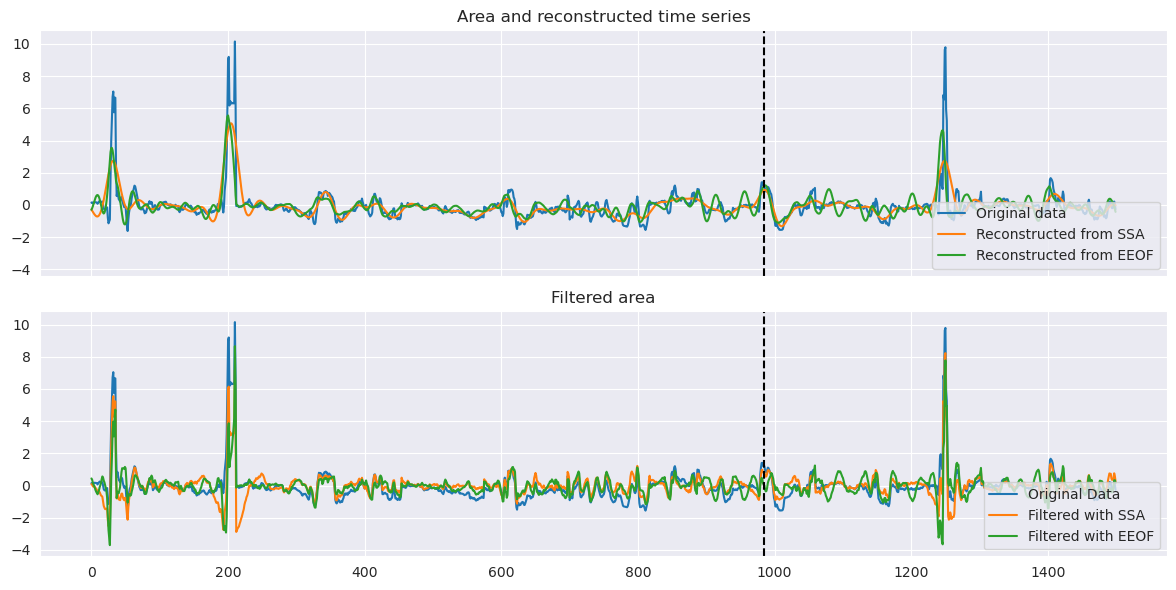

In [13]:
fig, ax = plt.subplots(2, figsize = (12, 6), sharex=True, sharey=True)
# ax[0].plot(era5_all['scaled_area'][:1500], label='Original data')
# ax[0].plot(ssa_area_all[:][:4].sum(axis=0)[:1500], label='Reconstructed from SSA')
# ax[0].plot(reconstructed_all[399:, 0][:1500], label='Reconstructed from EEOF')
# ax[0].axvline(x=1500-516, color='black', linestyle='--')
# ax[0].set_title('Area and reconstructed series on all data')
# ax[0].legend(loc='lower right')

ax[0].plot(era5_hannachi['scaled_area'][:1500], label='Original data')
ax[0].plot(ssa_area_hannachi[:][:7].sum(axis=0)[:1500], label='Reconstructed from SSA')
ax[0].plot(reconstructed_hannachi[399:, 0][:1500], label='Reconstructed from EEOF')
ax[0].axvline(x=1500-516, color='black', linestyle='--')
# ax[0].set_title('Area and reconstructed series on filtered (DJFM), then scaled data')
ax[0].set_title('Area and reconstructed time series')
ax[0].legend(loc='lower right')

ax[1].plot(era5_hannachi['scaled_area'][:1500], label='Original Data')
ax[1].plot(era5_hannachi['filtered_area_ssa'][:1500], label='Filtered with SSA')
ax[1].plot(era5_hannachi['filtered_area_eeof'][:1500], label='Filtered with EEOF')
ax[1].axvline(x=1500-516, color='black', linestyle='--')
ax[1].set_title('Filtered area')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.savefig('../output/ssa_eeof_era5.png')
plt.show()

## Optimal number of clusters
The authors focused on the Gap statistic which is also implemented below. Additionally elbow and silhouette methods are considered.

In [9]:
k_max = 10
gap_ar_latcent = arctic.gap_statistic(era5_hannachi[['scaled_ar', 'scaled_latcent']], k_max=k_max, n_replicates=15)
gap_ar_latcent_area = arctic.gap_statistic(era5_hannachi[['scaled_ar', 'scaled_latcent', 'scaled_area']], k_max=k_max, n_replicates=15)
gap_ar_latcent_filteredeeof = arctic.gap_statistic(era5_hannachi[['scaled_ar', 'scaled_latcent', 'filtered_area_eeof']], k_max=k_max, n_replicates=15)
gap_ar_latcent_filteredssa = arctic.gap_statistic(era5_hannachi[['scaled_ar', 'scaled_latcent', 'filtered_area_ssa']], k_max=k_max, n_replicates=15)

elbow_ar_latcent = arctic.elbow_method(era5_hannachi[['scaled_ar', 'scaled_latcent']], k_max=k_max)
elbow_ar_latcent_area = arctic.elbow_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'scaled_area']], k_max=k_max)
elbow_ar_latcent_filteredeeof = arctic.elbow_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'filtered_area_eeof']], k_max=k_max)
elbow_ar_latcent_filteredssa = arctic.elbow_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'filtered_area_ssa']], k_max=k_max)

silhouette_ar_latcent = arctic.silhouette_method(era5_hannachi[['scaled_ar', 'scaled_latcent']], k_max=k_max)
silhouette_ar_latcent_area = arctic.silhouette_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'scaled_area']], k_max=k_max)
silhouette_ar_latcent_filteredeeof = arctic.silhouette_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'filtered_area_eeof']], k_max=k_max)
silhouette_ar_latcent_filteredssa = arctic.silhouette_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'filtered_area_ssa']], k_max=k_max)

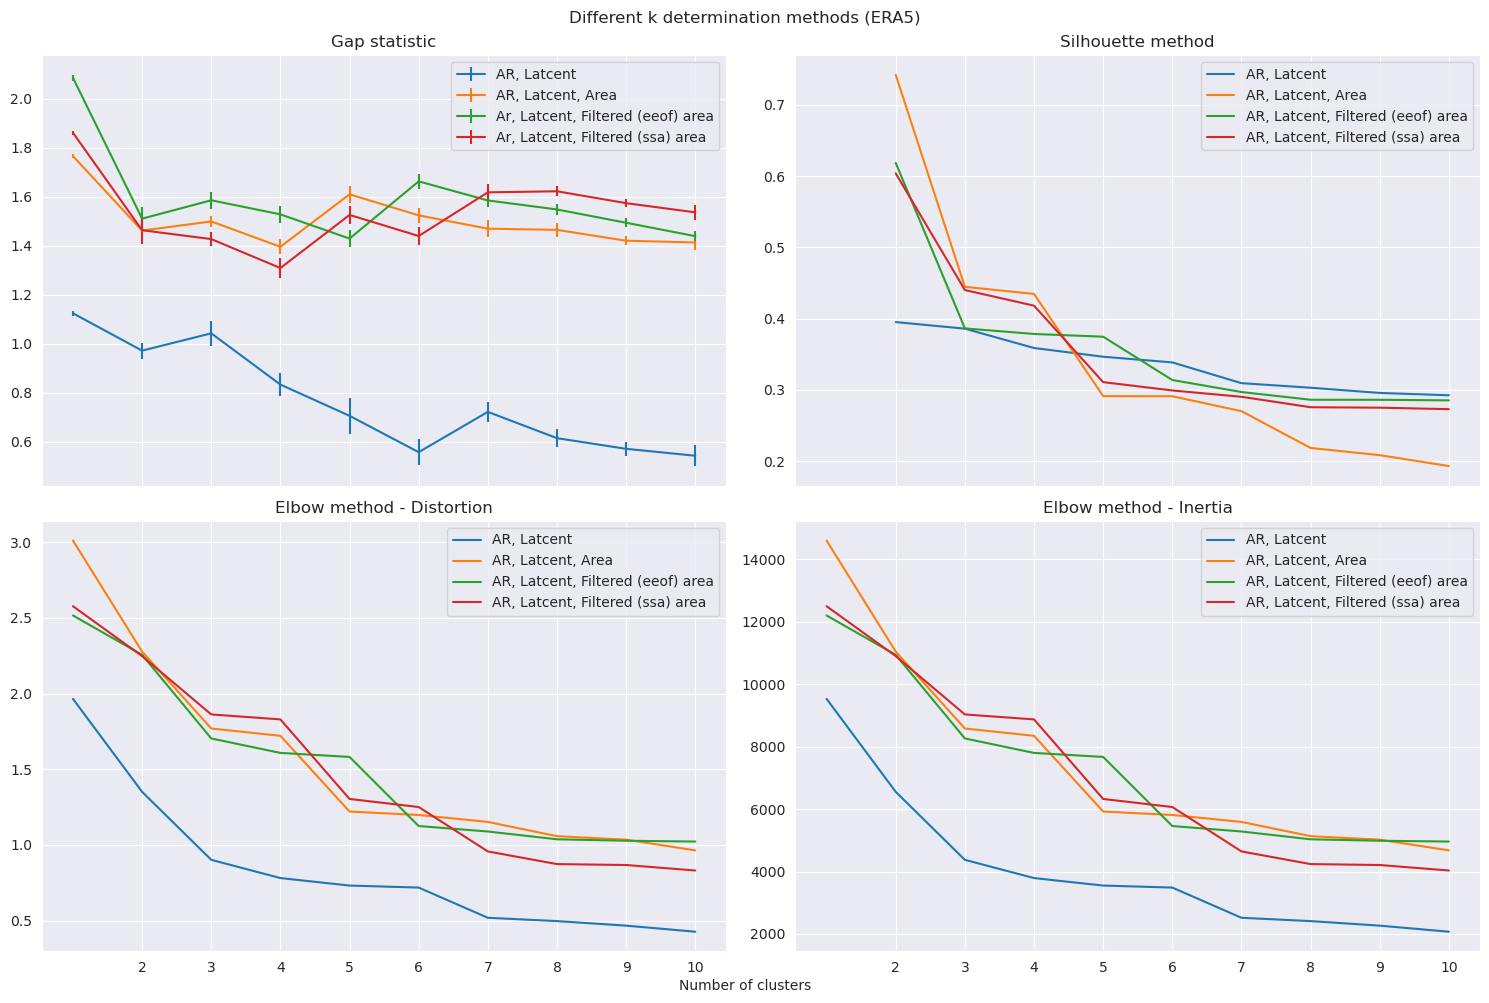

In [37]:
fig, ax = plt.subplots(2,2, figsize=(15, 10), sharex=True)
ax[0][0].errorbar(np.arange(1,11), gap_ar_latcent[:, 0], yerr=gap_ar_latcent[:, 1], label='AR, Latcent')
ax[0][0].errorbar(np.arange(1,11), gap_ar_latcent_area[:, 0], yerr=gap_ar_latcent_area[:, 1], label='AR, Latcent, Area')
ax[0][0].errorbar(np.arange(1,11), gap_ar_latcent_filteredeeof[:, 0], yerr=gap_ar_latcent_filteredeeof[:, 1], label='Ar, Latcent, Filtered (eeof) area')
ax[0][0].errorbar(np.arange(1,11), gap_ar_latcent_filteredssa[:, 0], yerr=gap_ar_latcent_filteredssa[:, 1], label='Ar, Latcent, Filtered (ssa) area')
ax[0][0].set_title('Gap statistic')
ax[0][0].legend()

ax[1][0].plot(np.arange(1,11), elbow_ar_latcent[0], label='AR, Latcent')
ax[1][0].plot(np.arange(1,11), elbow_ar_latcent_area[0], label='AR, Latcent, Area')
ax[1][0].plot(np.arange(1,11), elbow_ar_latcent_filteredeeof[0], label='AR, Latcent, Filtered (eeof) area')
ax[1][0].plot(np.arange(1,11), elbow_ar_latcent_filteredssa[0], label='AR, Latcent, Filtered (ssa) area')
ax[1][0].set_title('Elbow method - Distortion')
ax[1][0].legend()

ax[1][1].plot(np.arange(1,11), elbow_ar_latcent[1], label='AR, Latcent')
ax[1][1].plot(np.arange(1,11), elbow_ar_latcent_area[1], label='AR, Latcent, Area')
ax[1][1].plot(np.arange(1,11), elbow_ar_latcent_filteredeeof[1], label='AR, Latcent, Filtered (eeof) area')
ax[1][1].plot(np.arange(1,11), elbow_ar_latcent_filteredssa[1], label='AR, Latcent, Filtered (ssa) area')
ax[1][1].set_title('Elbow method - Inertia')
ax[1][1].legend()

ax[0][1].plot(np.arange(2,11), silhouette_ar_latcent, label='AR, Latcent')
ax[0][1].plot(np.arange(2,11), silhouette_ar_latcent_area, label='AR, Latcent, Area')
ax[0][1].plot(np.arange(2,11), silhouette_ar_latcent_filteredeeof, label='AR, Latcent, Filtered (eeof) area')
ax[0][1].plot(np.arange(2,11), silhouette_ar_latcent_filteredssa, label='AR, Latcent, Filtered (ssa) area')
ax[0][1].set_title('Silhouette method')
ax[0][1].legend()

plt.suptitle('Different k determination methods (ERA5)')
plt.xticks(np.arange(2, 11))
fig.text(0.5, 0, 'Number of clusters', ha='center')
plt.tight_layout()
plt.savefig('../output/Kopt_era5.png')
plt.show()

In [11]:
print("Optimal number of clusters by each method: ")
p_1, p_2, p_3, p_4 = 1,1,1,1
for k in range(1, 10):
    if p_1 and (gap_ar_latcent[k][0] >= gap_ar_latcent[k+1][0] - gap_ar_latcent[k+1][1]):
        print('Gap statistic (AR, Latcent): ', k+1)
        p_1=0
    if p_2 and (gap_ar_latcent_area[k][0] >= gap_ar_latcent_area[k+1][0] - gap_ar_latcent_area[k+1][1]):
        print("Gap statistic (AR, Latcent, Area): ", k+1)
        p_2 = 0
    if p_3 and (gap_ar_latcent_filteredeeof[k][0] >= gap_ar_latcent_filteredeeof[k+1][0] - gap_ar_latcent_filteredeeof[k+1][1]):
        print("Gap statistic (AR, Latcent, EEOF filtered area): ", k+1)
        p_3=0
    if p_4 and (gap_ar_latcent_filteredssa[k][0] >= gap_ar_latcent_filteredssa[k+1][0] - gap_ar_latcent_filteredssa[k+1][1]):
        print("Gap statistic (AR, Latcent, SSA filtered Area): ", k+1)
        p_4 = 0

print("Silhouette method (AR, Latcent): ", pd.DataFrame(silhouette_ar_latcent).idxmax()[0]+2)
print("Silhouette method (AR, latcent, Area): ", pd.DataFrame(silhouette_ar_latcent_area).idxmax()[0]+2)
print("Silhouette method (AR, latcent, EEOF filtered Area): ", pd.DataFrame(gap_ar_latcent_filteredeeof).idxmax()[0]+2)
print("Silhouette method (AR, latcent, SSA filtered Area): ", pd.DataFrame(gap_ar_latcent_filteredssa).idxmax()[0]+2)

Optimal number of clusters by each method: 
Gap statistic (AR, Latcent, SSA filtered Area):  2
Gap statistic (AR, Latcent):  3
Gap statistic (AR, Latcent, Area):  3
Gap statistic (AR, Latcent, EEOF filtered area):  3
Silhouette method (AR, Latcent):  2
Silhouette method (AR, latcent, Area):  2
Silhouette method (AR, latcent, EEOF filtered Area):  2
Silhouette method (AR, latcent, SSA filtered Area):  2


### Optimal number of clusters
Both, the gap statistic and silhouette method, indicate clearly that the data are not structured. When disregarding k_opt = 1, all methods indicate clearly k_opt = 2 for AR and Latcent. As soon as the area is added, it becomes less clear.

#### Gap statistic
The gap statistic indicates:
- k_opt = 3 for AR, Latcent (+ scaled Area)
- k_opt = 2 for AR, Latcent, filtered (scaled) Area

#### Silhouette statistic
The silhouette method indicates clearly k_opt = 2 for all combinations

#### Elbow method
The elbow method indicates:
- k_opt = 3 and AR, Latcent, (+ Area/filtered Area)
- k_opt = 5 and AR, Latcent, (SSA filtered) Area

## Results
Proceed with k_opt = 3 and any combination. Here, the features used by Hannachi et al. are considered for further classification.


## Optimal number of clusters does not align with results from Hannachi et al.

### Possible reasons
- different data: Hannachi et al. used era40 data, here era5 used
- different aggregation: Only aggregated era5 data were processed. Methods to compute latcent and area may differ.
- different scaling: The used scaling could be different (likely with respect to the absolut numbers in plots)
- no autocorrelation detected &rArr; filtering could introduce bias

## Explorative analysis to get more insights into data
### Correlation

In [12]:
arctic.plot_correlation(era5_hannachi)


### PCA

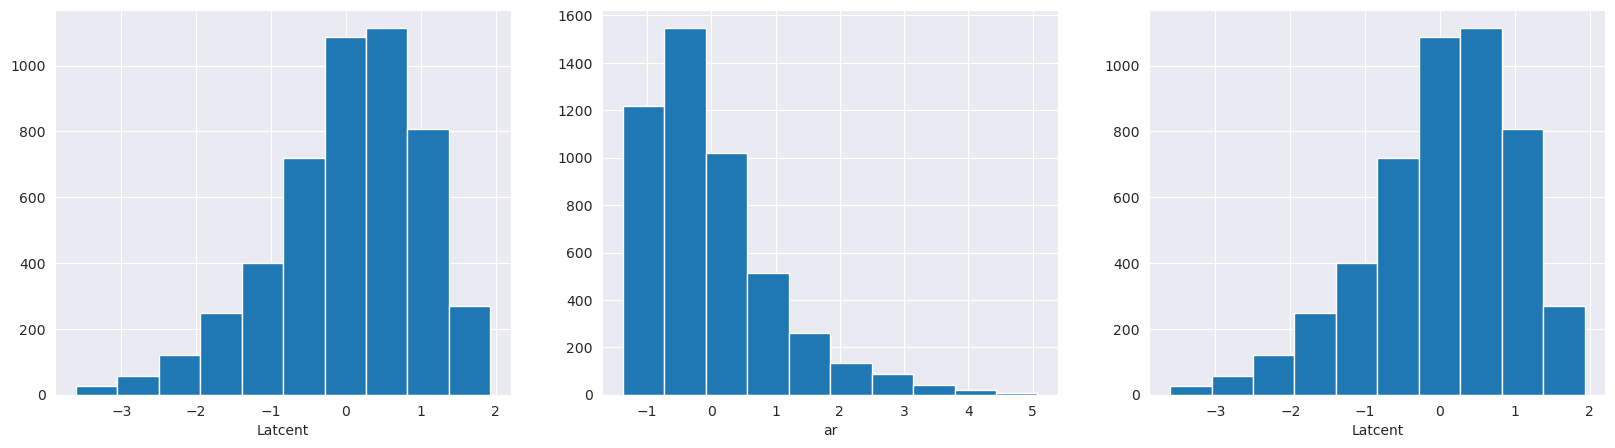

PCA on AR, latcent:
Eigenvalues: [1.00594546 0.95992257]
PCA on scaled values:
Eigenvalues: [1.17039986 0.99979114 0.84198632]


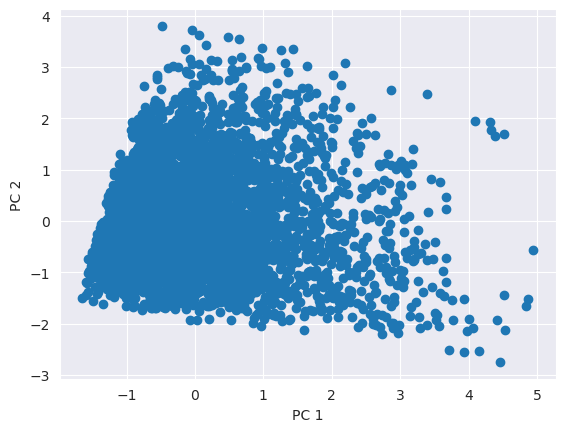

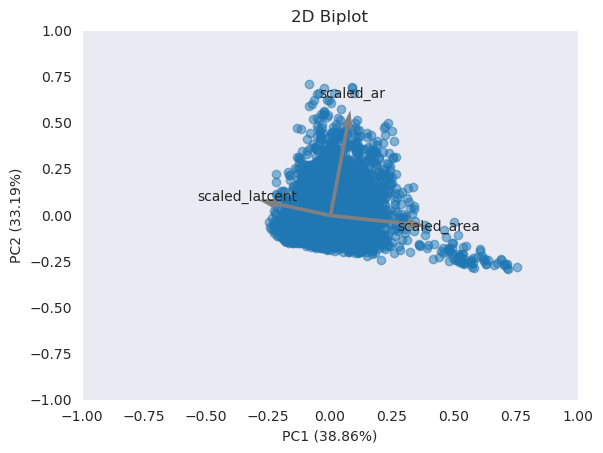

PCA on scaled values and EEOF filtered area:
Eigenvalues: [1.00691752 0.96343898 0.54650155]


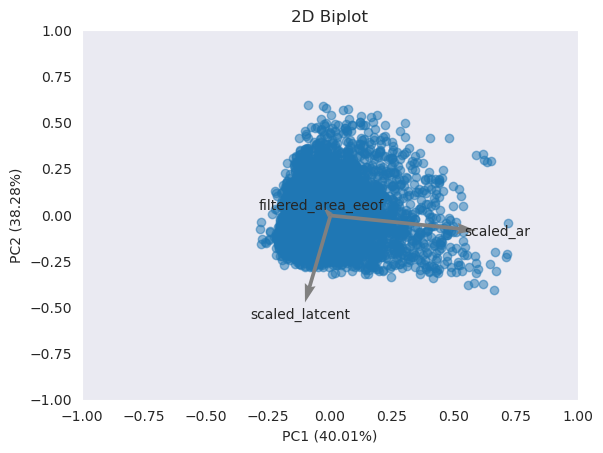

PCA on scaled values and SSA filtered area:
Eigenvalues: [1.00826538 0.96422261 0.60564185]


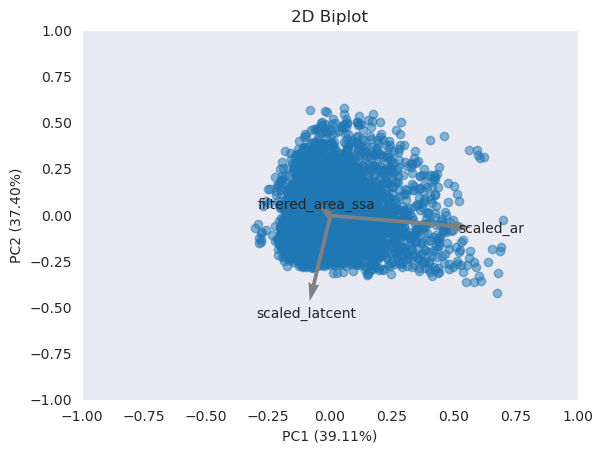

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(era5_hannachi['scaled_latcent'])
ax[0].set_xlabel('Latcent')
ax[1].hist(era5_hannachi['scaled_ar'])
ax[1].set_xlabel('ar')
ax[2].hist(era5_hannachi['scaled_latcent'])
ax[2].set_xlabel('Latcent')
plt.show()

print('PCA on AR, latcent:')
x_new, scores, pca = arctic.compute_pca(era5_hannachi[['scaled_ar', 'scaled_latcent']], scaler=None, n_comp=2)
print('Eigenvalues:', pca.explained_variance_)
# arctic.plot_pca(pca, x_new, features=['scaled_ar', 'scaled_latcent'])
plt.scatter(x_new[:, 0], x_new[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')

print('PCA on scaled values:')
x_new, scores, pca = arctic.compute_pca(era5_hannachi[['scaled_ar', 'scaled_latcent', 'scaled_area']], scaler=None, n_comp=3)
print('Eigenvalues:', pca.explained_variance_)
arctic.plot_pca(pca, x_new, features=['scaled_ar', 'scaled_latcent', 'scaled_area'])

print('PCA on scaled values and EEOF filtered area:')
x_new, scores, pca = arctic.compute_pca(era5_hannachi[['scaled_ar', 'scaled_latcent', 'filtered_area_eeof']], scaler=None, n_comp=3)
print('Eigenvalues:', pca.explained_variance_)
arctic.plot_pca(pca, x_new, features=['scaled_ar', 'scaled_latcent', 'filtered_area_eeof'])

print('PCA on scaled values and SSA filtered area:')
x_new, scores, pca = arctic.compute_pca(era5_hannachi[['scaled_ar', 'scaled_latcent', 'filtered_area_ssa']], scaler=None, n_comp=3)
print('Eigenvalues:', pca.explained_variance_)
arctic.plot_pca(pca, x_new, features=['scaled_ar', 'scaled_latcent', 'filtered_area_ssa'])

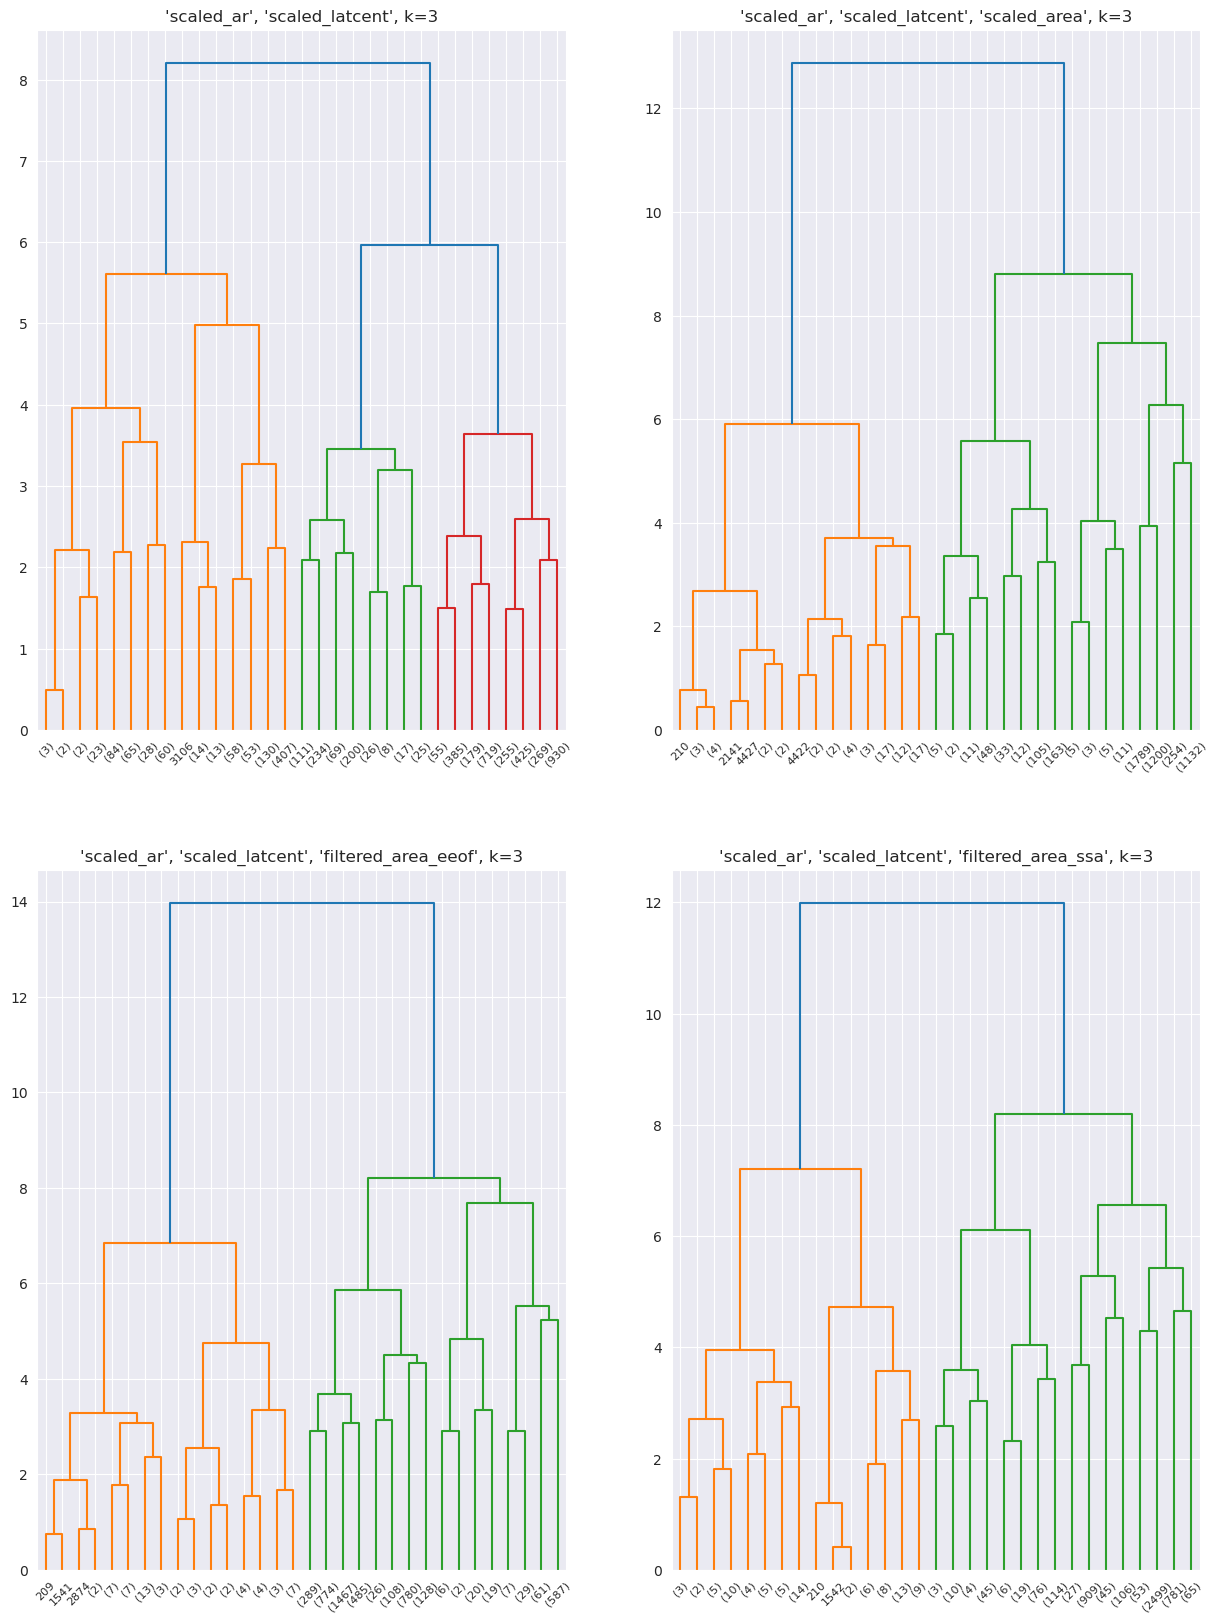

In [14]:
from sklearn import clone
from sklearn.cluster import AgglomerativeClustering

features_kopt = [{'features' : ['scaled_ar', 'scaled_latcent'], 'k_opt' : 3},
                 {'features' : ['scaled_ar', 'scaled_latcent', 'scaled_area'], 'k_opt' : 3},
                 {'features' : ['scaled_ar', 'scaled_latcent', 'filtered_area_eeof'], 'k_opt' : 3},
                 {'features' : ['scaled_ar', 'scaled_latcent', 'filtered_area_ssa'], 'k_opt' : 3}]


Y = []
base_model = AgglomerativeClustering(linkage='complete', compute_distances=True)

fig = plt.figure(figsize=(15,20))
for idx, feat_k in enumerate(features_kopt):
    model = clone(base_model)
    model.set_params(n_clusters = feat_k['k_opt'])
    model.fit(era5_hannachi[feat_k['features']])
    ax = fig.add_subplot(2,2,idx+1)
    ax.set_title(str(feat_k['features'])[1:-1]+", k="+str(feat_k['k_opt']))
    arctic.plot_dendrogram(model, truncate_mode='level', p=4, savefig=f"../output/hc_{'_'.join(feat_k['features'])}_{feat_k['k_opt']}.png")
    y_pred = model.labels_.astype(int)
    Y.append(y_pred)


### Number of clusters from dendrograms aligns with results from Hannachi et al.

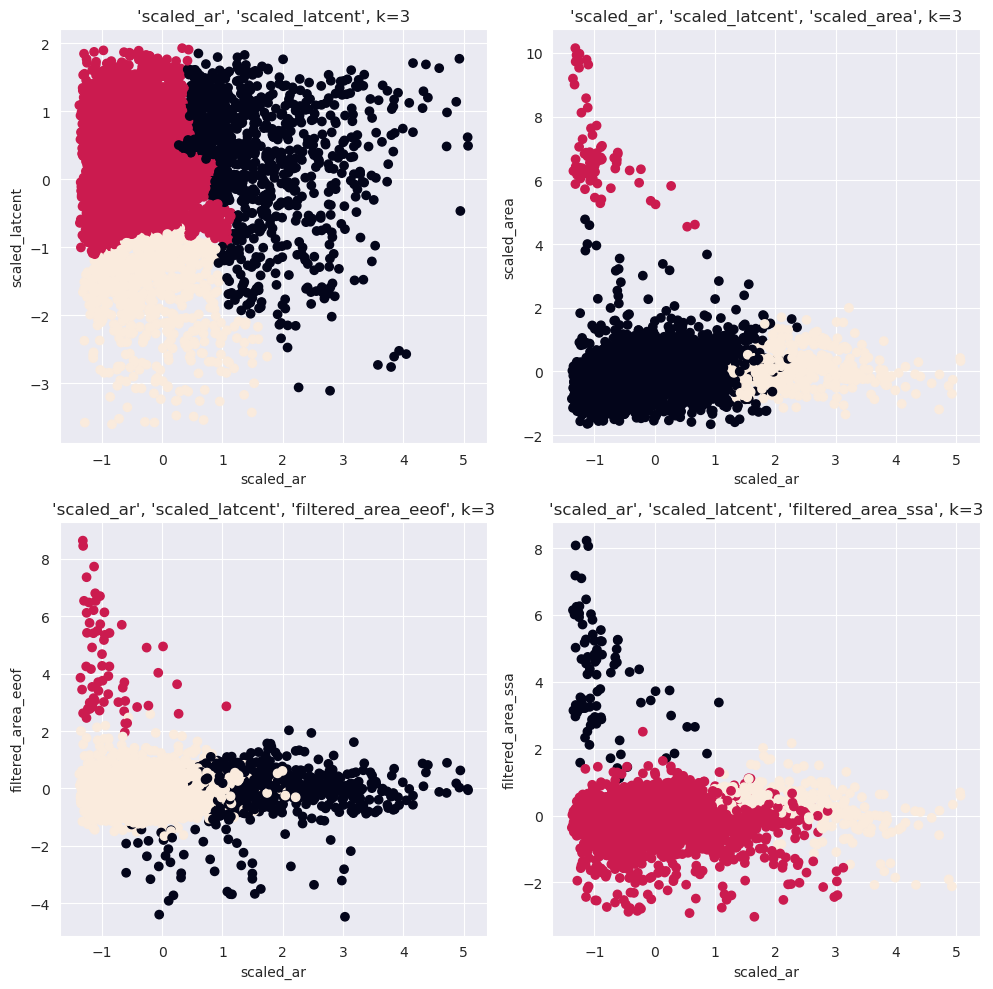

In [15]:
fig = plt.figure(figsize=(10,10))
for idx, feat_k in enumerate(features_kopt):
    ax = fig.add_subplot(2,2, idx+1)
    ax.scatter(era5_hannachi[feat_k['features']].iloc[:, 0], era5_hannachi[feat_k['features']].iloc[:, -1],
                c=Y[idx])
    ax.set_xlabel(feat_k['features'][0])
    ax.set_ylabel(feat_k['features'][-1])
    ax.set_title(str(feat_k['features'])[1:-1]+", k="+str(feat_k['k_opt']))
plt.tight_layout()
plt.show()

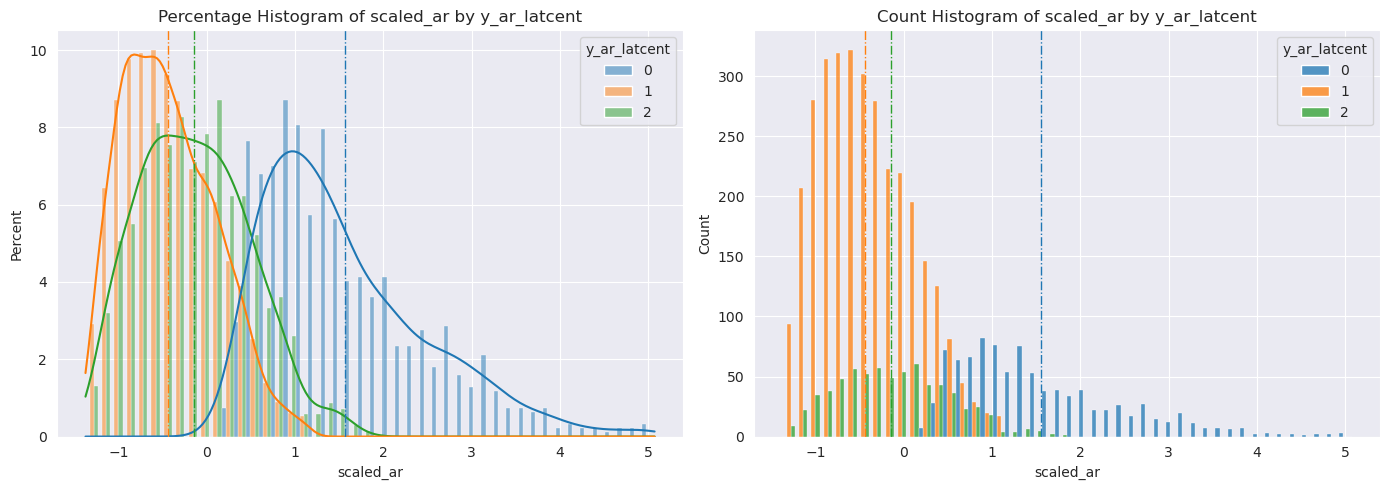

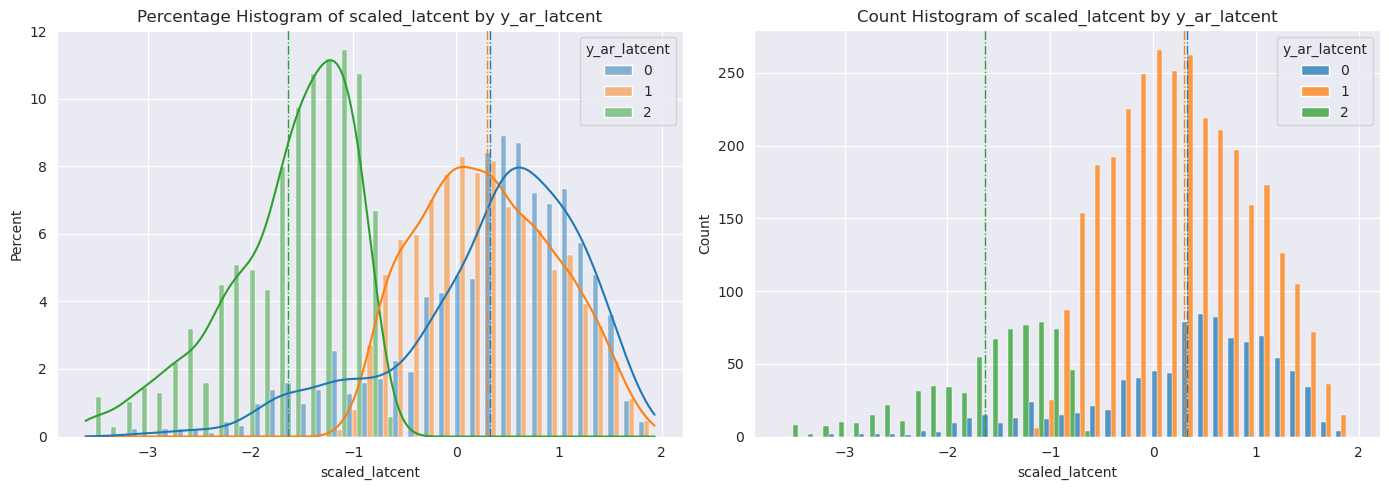

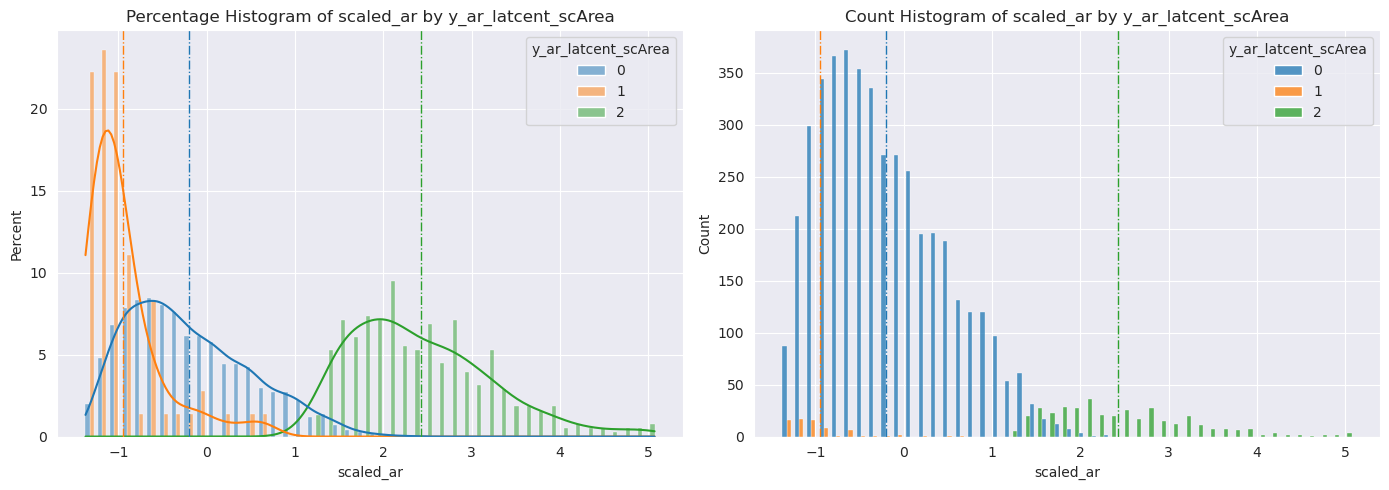

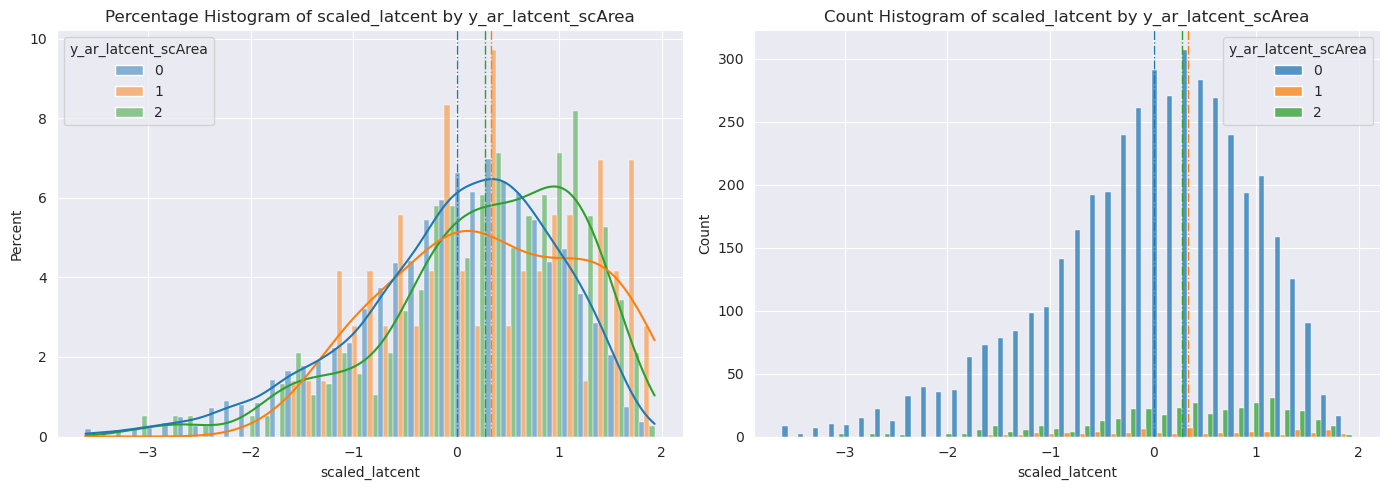

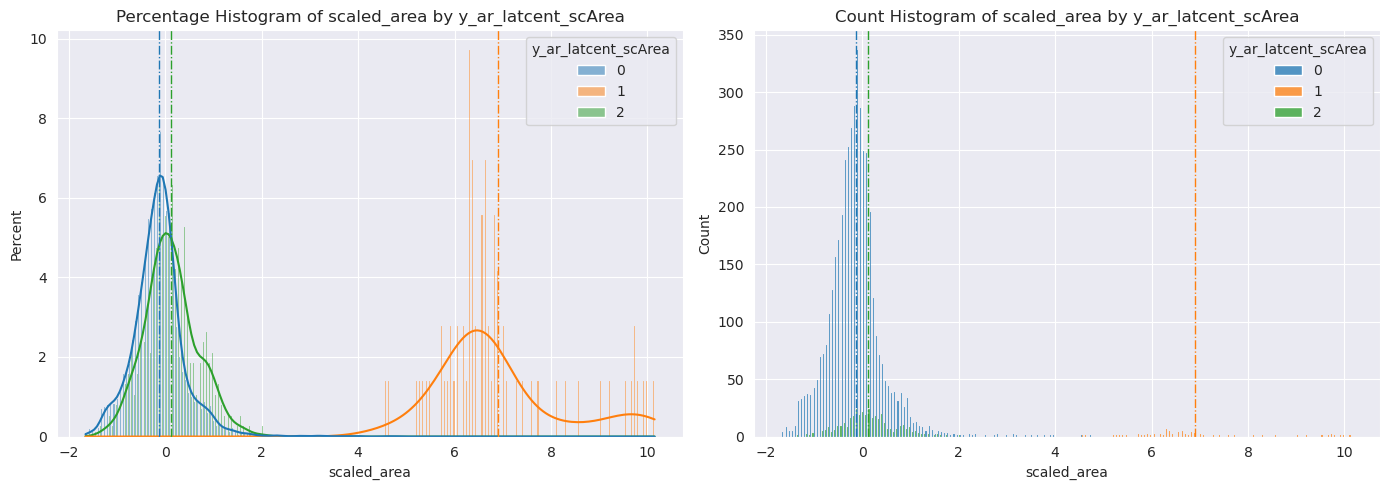

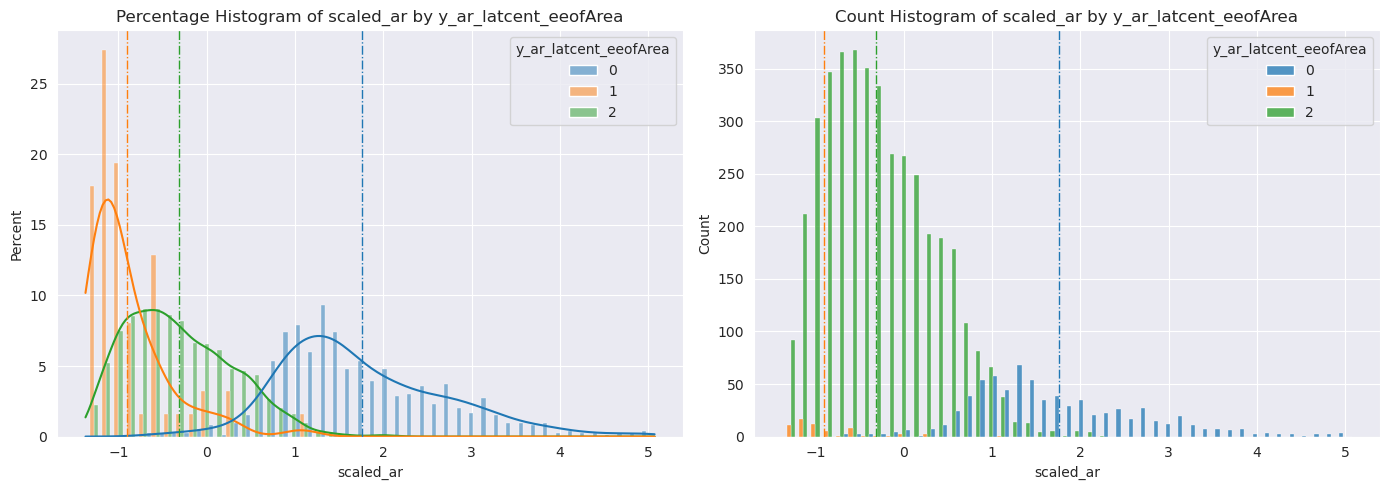

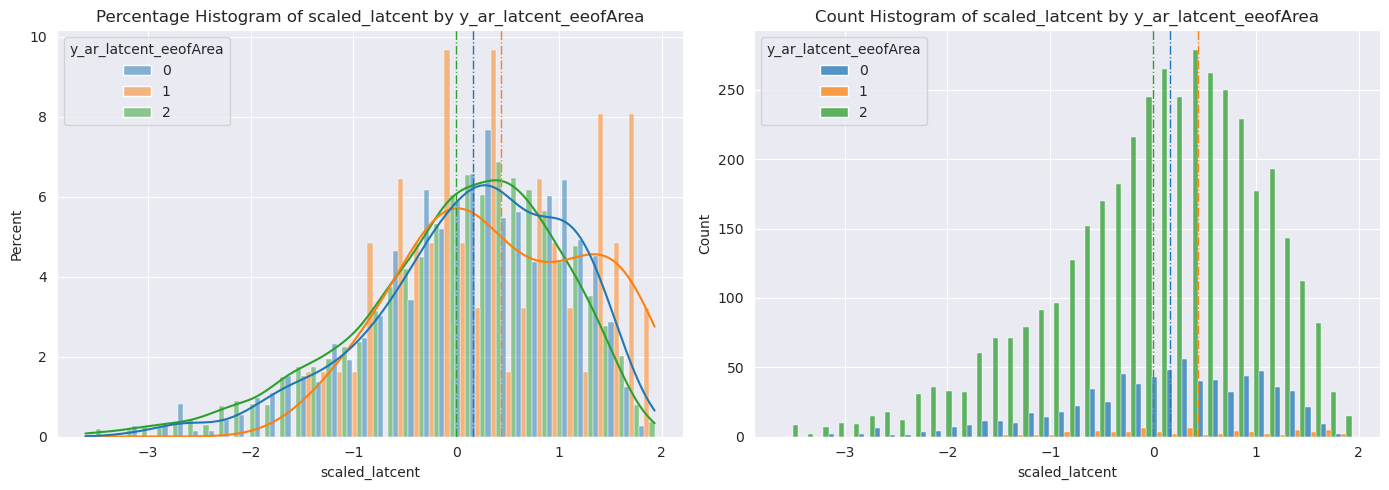

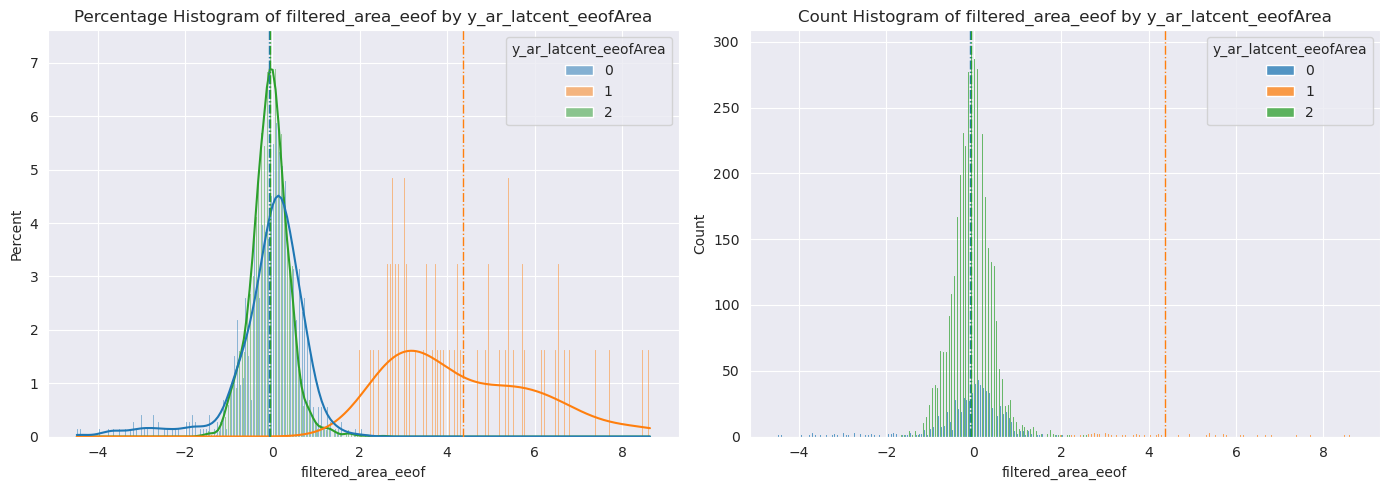

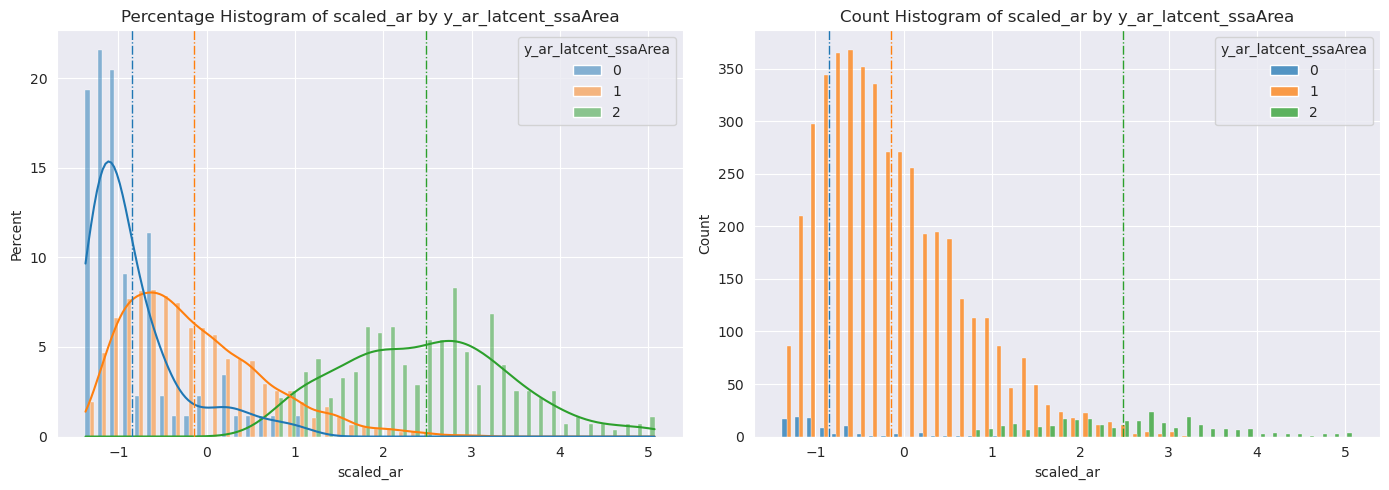

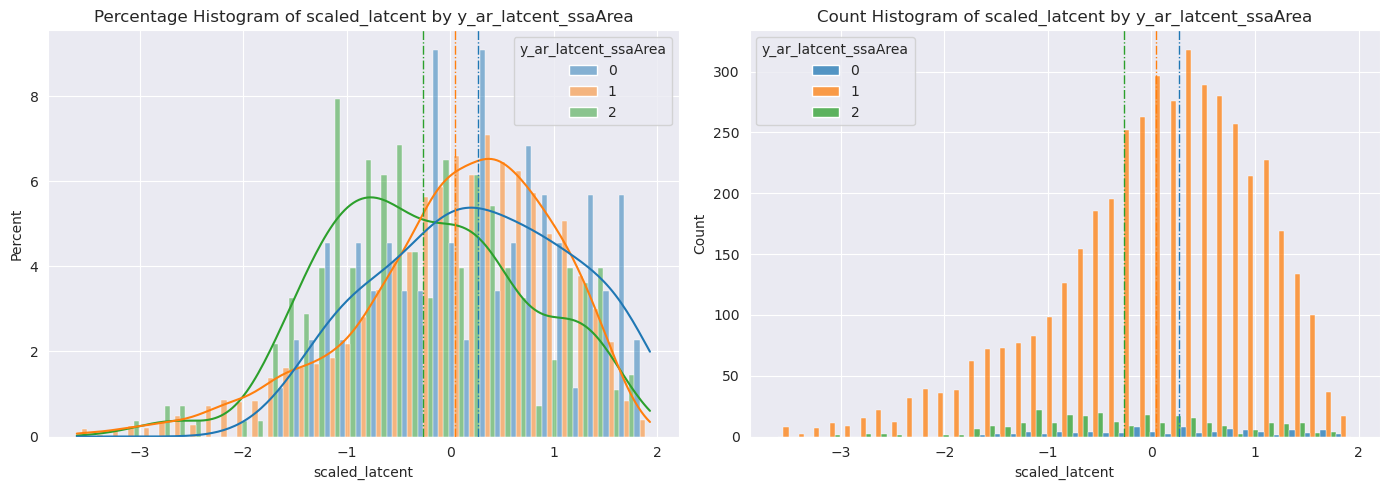

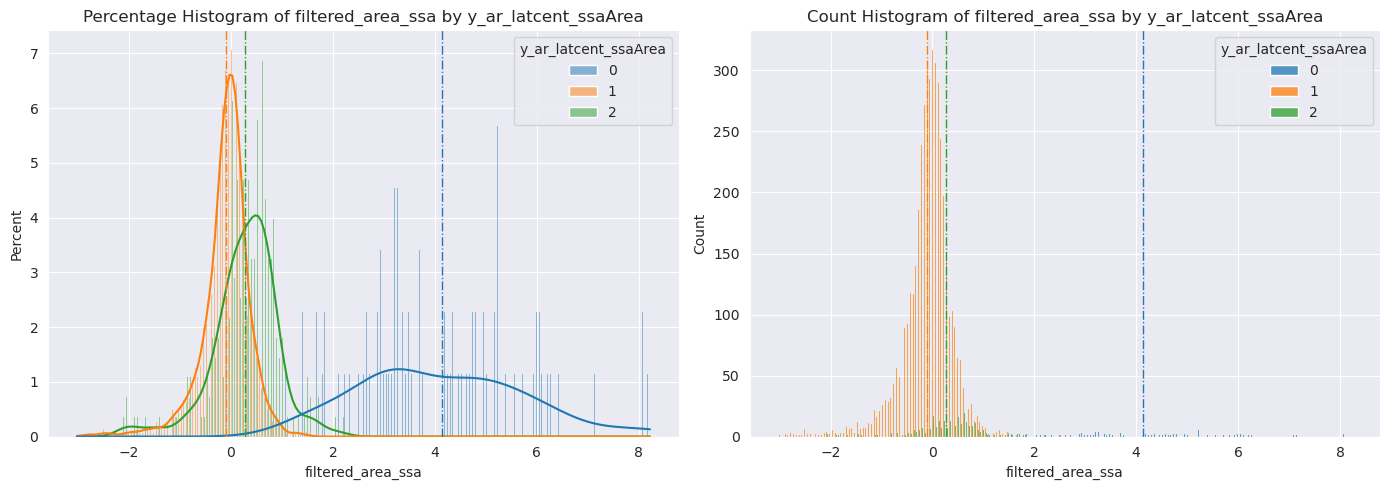

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

y_names = ['y_ar_latcent', 'y_ar_latcent_scArea', 'y_ar_latcent_eeofArea', 'y_ar_latcent_ssaArea']
era5_hannachi[y_names] = pd.DataFrame(Y).T

for idx, feat_k in enumerate(features_kopt):
    var = y_names[idx]
    for feature in feat_k['features']:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Histogram with percentages
        sns.histplot(data=era5_hannachi,
                     x=feature,
                     hue=var,
                     palette='tab10',
                     common_norm=False,
                     multiple='dodge',
                     stat='percent',
                     kde=True,
                     ax=axes[0])
        axes[0].set_title(f"Percentage Histogram of {feature} by {var}")
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('Percent')

        group_means = era5_hannachi.groupby(var)[feature].mean()
        unique_classes = sorted(era5_hannachi[var].dropna().unique())
        palette = sns.color_palette('tab10', len(unique_classes))

        # Draw one vertical line per class, with matching color
        for i, label in enumerate(unique_classes):
            mean_val = group_means[label]
            axes[0].axvline(mean_val, color=palette[i], linewidth=1, linestyle='-.',
                            label=f"Mean of {var} = {label}")
            axes[1].axvline(mean_val, color=palette[i], linewidth=1, linestyle='-.',
                            label=f"Mean of {var} = {label}")
        # axes[0].legend()

        # Histogram with counts
        sns.histplot(data=era5_hannachi,
                     x=feature,
                     hue=var,
                     palette='tab10',
                     common_norm=False,
                     multiple='dodge',
                     stat='count',
                     kde=False,
                     ax=axes[1])
        axes[1].set_title(f"Count Histogram of {feature} by {var}")
        axes[1].set_xlabel(feature)
        axes[1].set_ylabel('Count')

        plt.tight_layout()
        plt.show()


y:  y_ar_latcent
class:  1


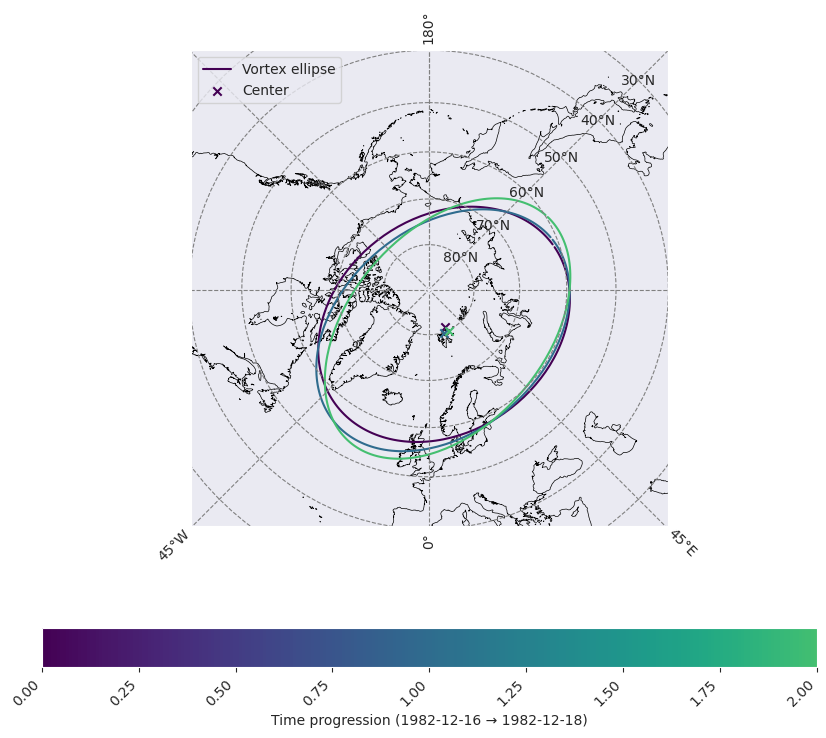

class:  0
split event in time range


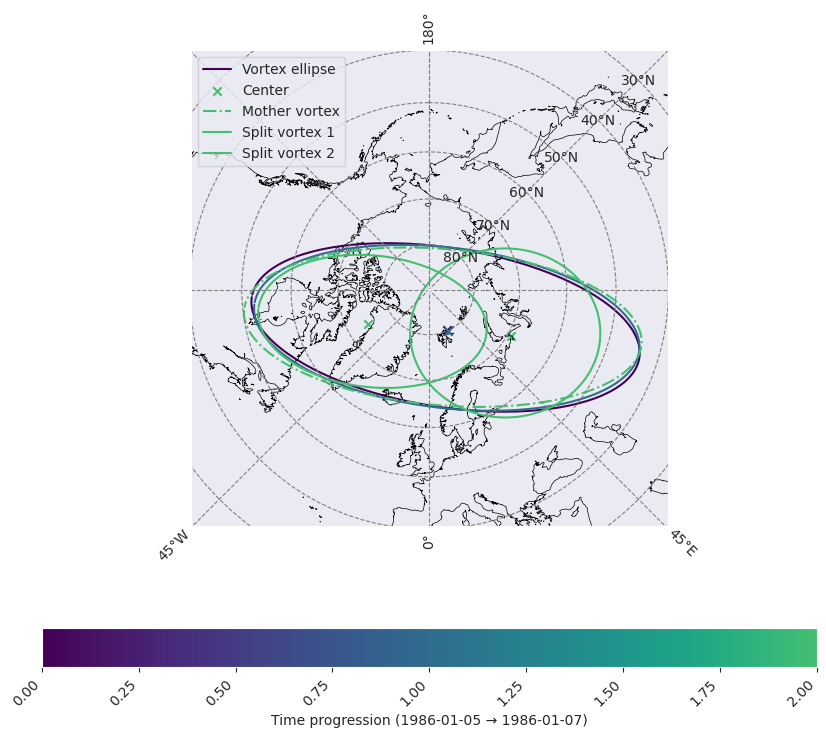

class:  2


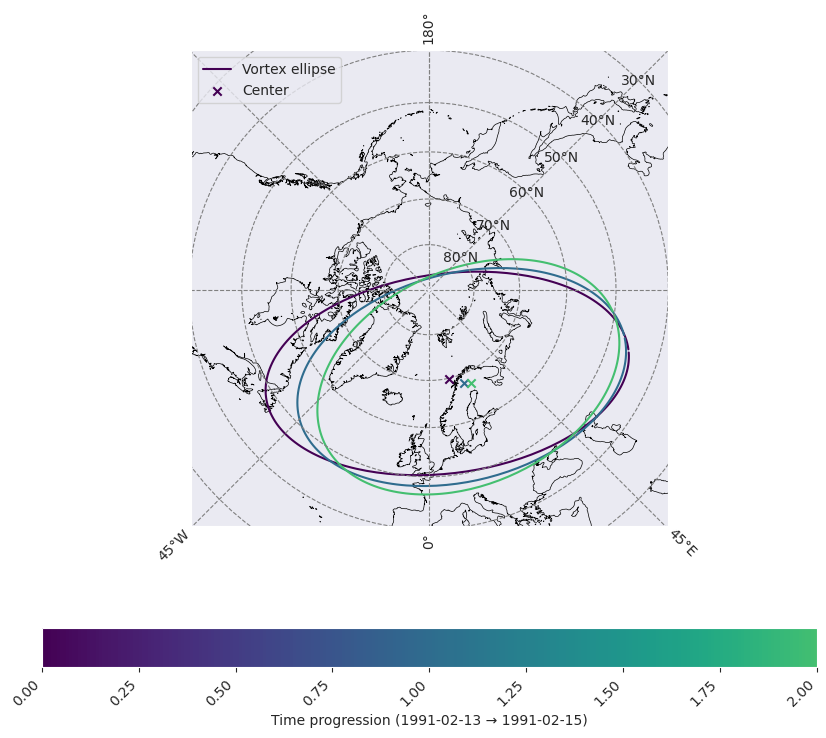

y:  y_ar_latcent_scArea
class:  0


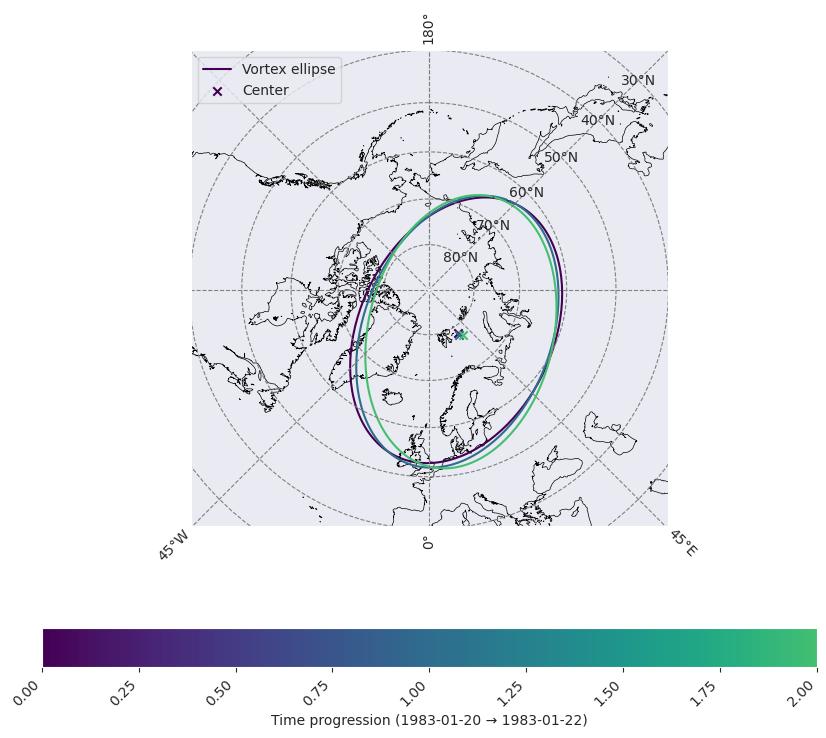

class:  2
split event in time range


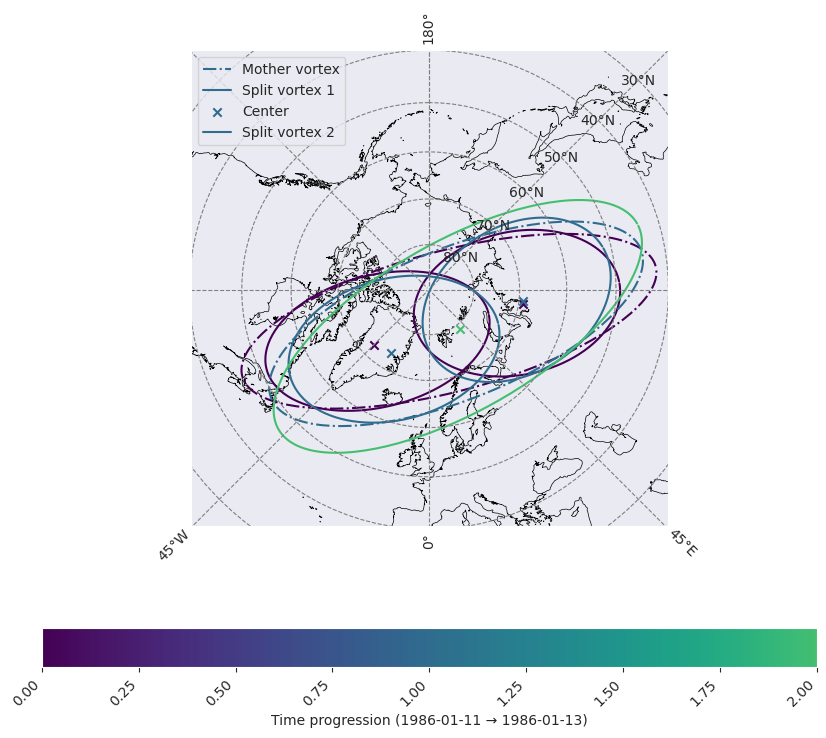

class:  1


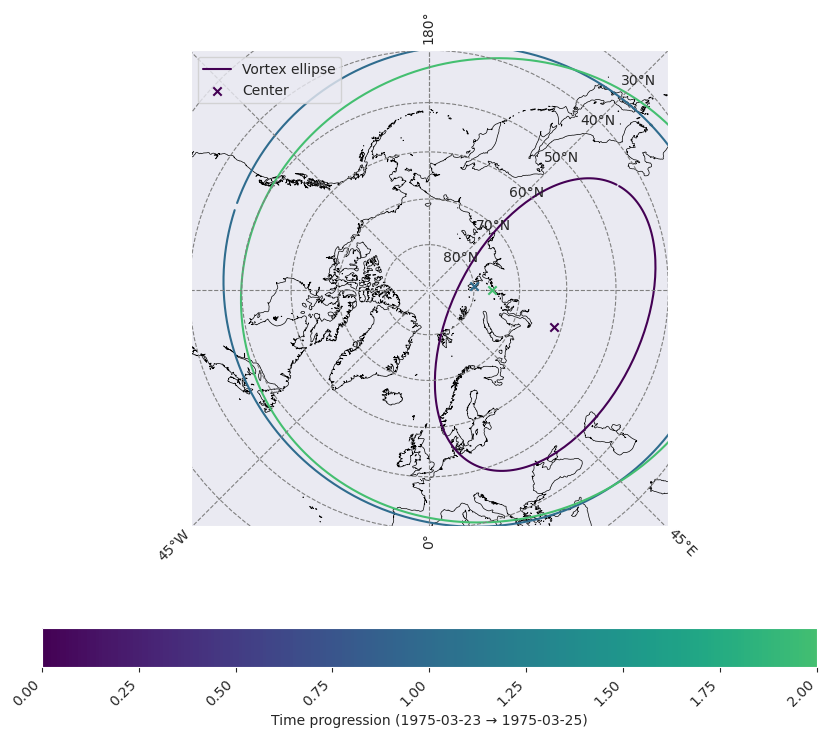

y:  y_ar_latcent_eeofArea
class:  2


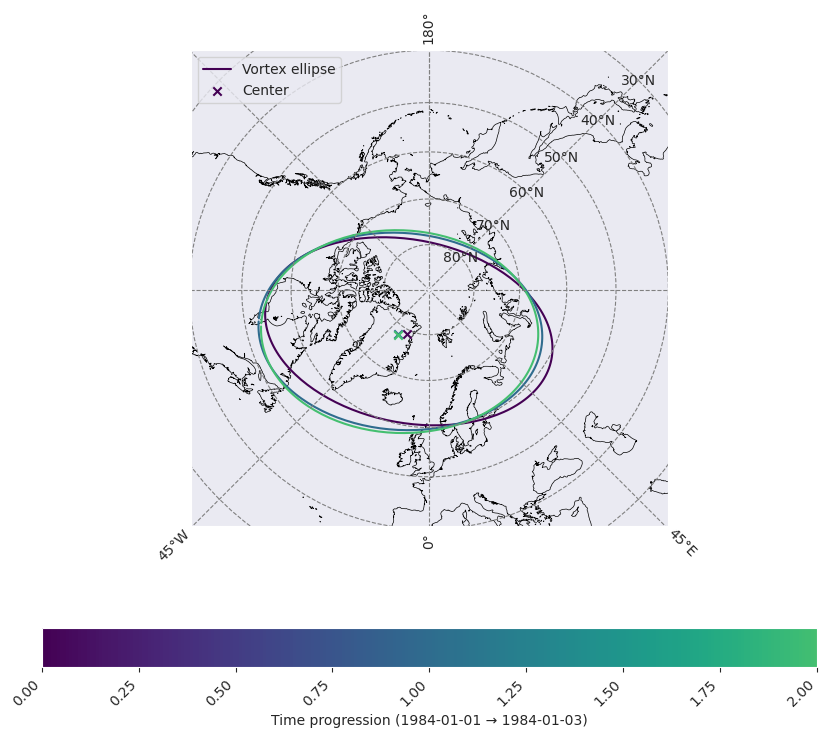

class:  0
split event in time range


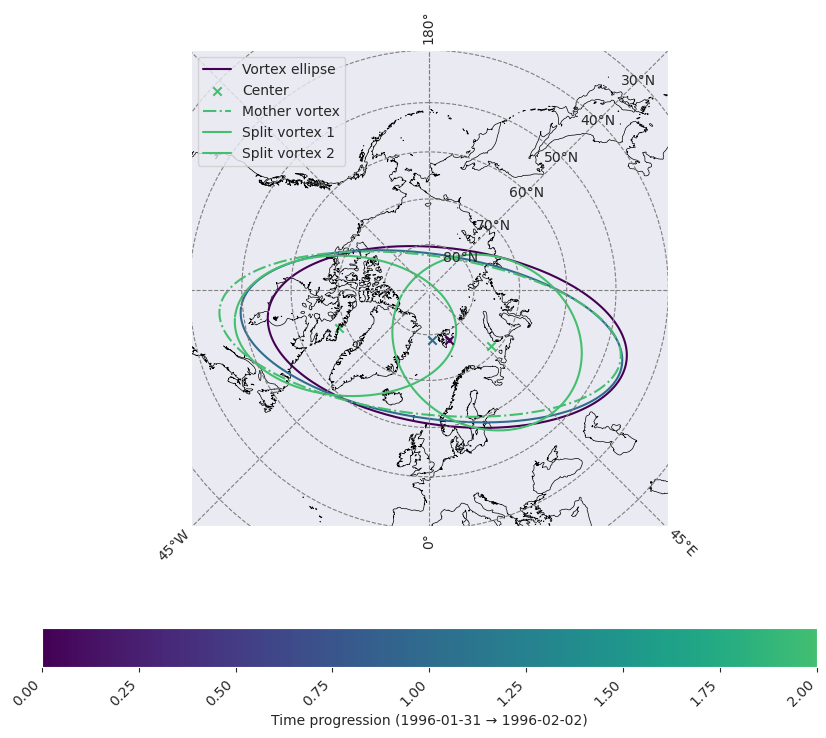

class:  1
MW event in time range


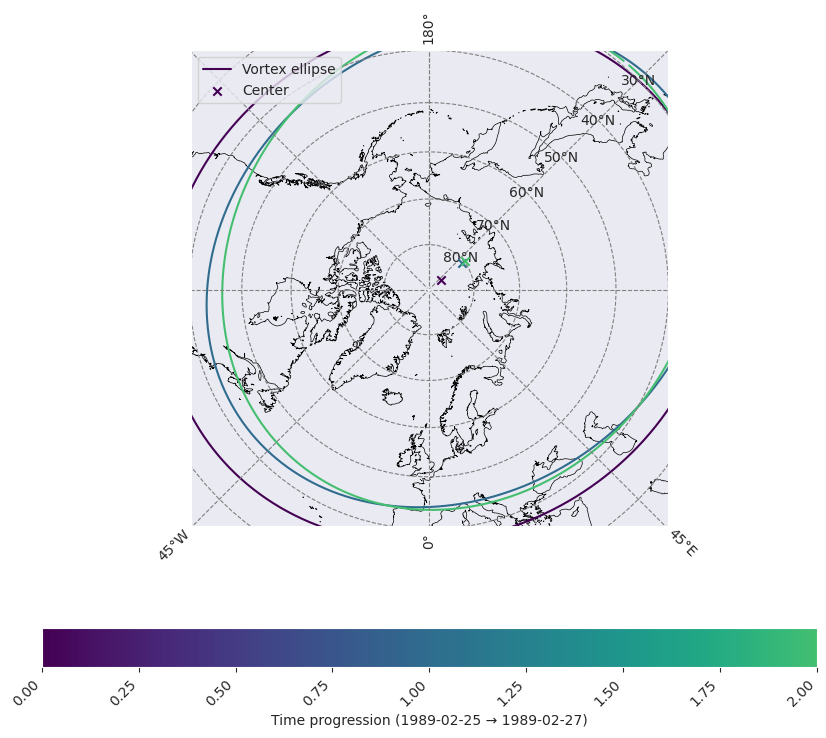

y:  y_ar_latcent_ssaArea
class:  1


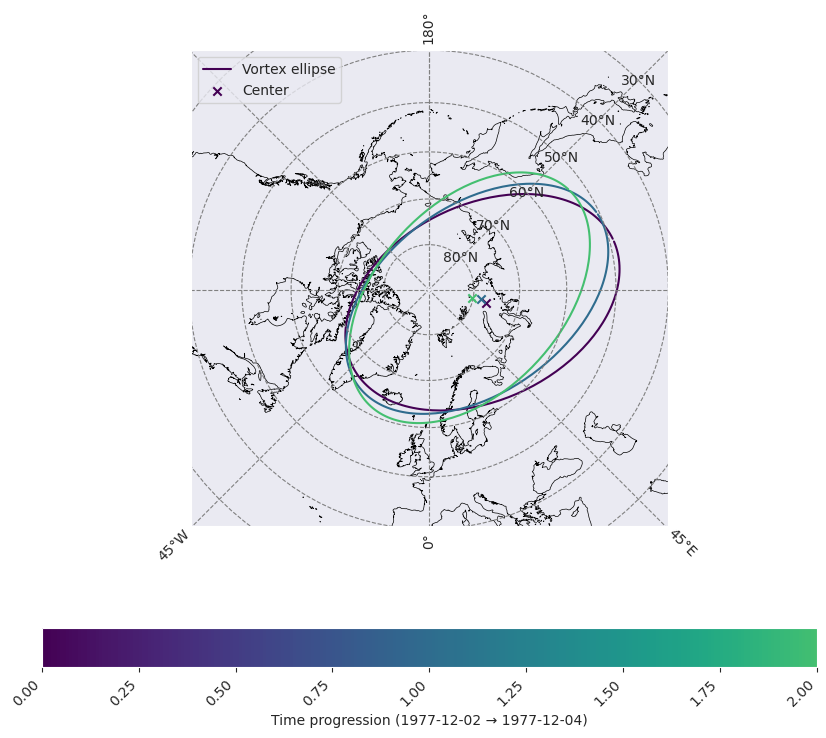

class:  2
split event in time range


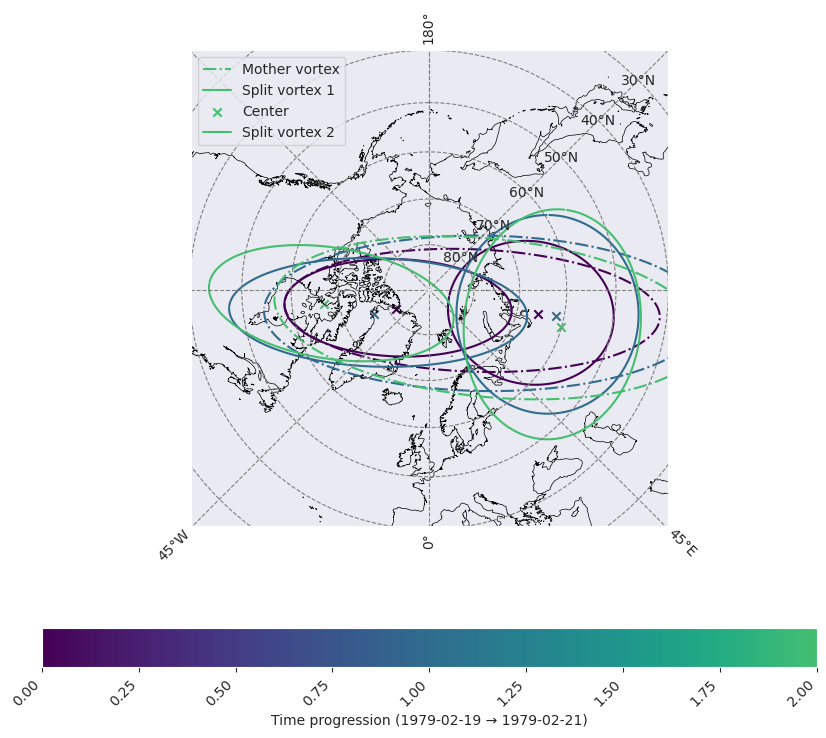

class:  0


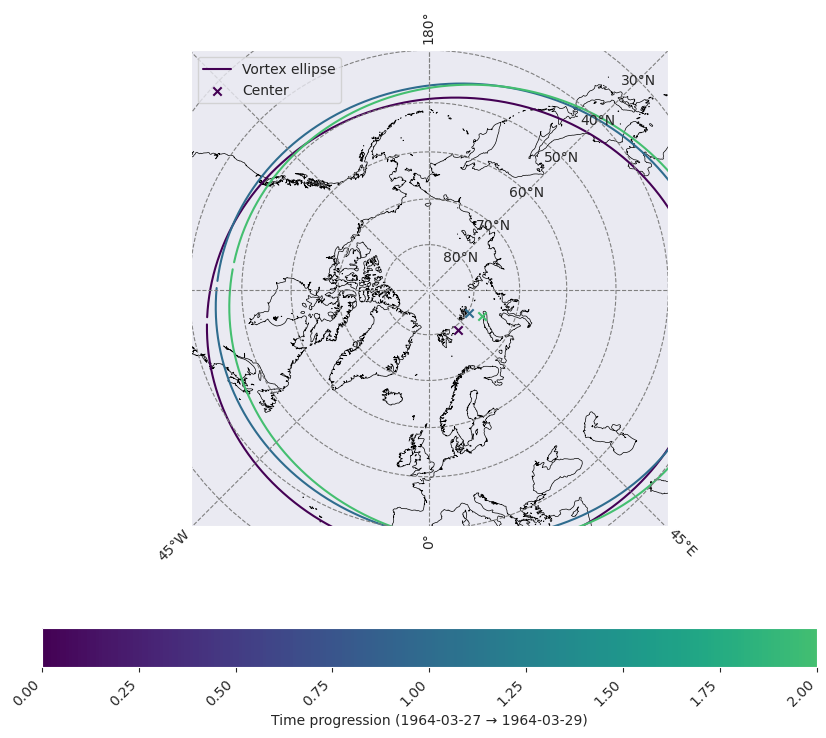

In [17]:
from sklearn.metrics.pairwise import euclidean_distances
from datetime import timedelta

foi = ['ar', 'latcent', 'kurtosis',
       'scaled_area', 'scaled_ar', 'scaled_latcent', 'scaled_kurtosis',
       'filtered_area_eeof', 'filtered_area_ssa']
for y in y_names:
    print('y: ', y)
    for c in era5_hannachi[y].unique():
        print('class: ', c)
        mean_vec = era5_hannachi[era5_hannachi[y] == c][foi].mean()
        dist_mean = euclidean_distances(era5_hannachi[foi], [mean_vec])
        mean_idx = dist_mean.argmin()
        rep_mean = era5_hannachi.iloc[mean_idx]

        dates = [rep_mean.string + timedelta(days=i) for i in range(-1, 2)]
        samples = era5_all[era5_all.string.isin(dates)]
        if samples.form.sum() > 0:
            print('split event in time range')
        if samples.MW.sum() > 0:
            print('MW event in time range')

        arctic.plot_polar_stereo(samples, time_col='string', mode='overlay', figsize=(10,10))


In [18]:
pd.pivot_table(data=era5_hannachi[['y_ar_latcent_scArea', 'string','y_ar_latcent_ssaArea']], index='y_ar_latcent_scArea', columns='y_ar_latcent_ssaArea', aggfunc = 'count', margins=True)/era5_hannachi.shape[0]*100

string                                 
y_ar_latcent_ssaArea         0          1         2         All
y_ar_latcent_scArea                                            
0                     0.329897  88.927835  1.443299   90.701031
1                     1.484536        NaN       NaN    1.484536
2                          NaN   3.546392  4.268041    7.814433
All                   1.814433  92.474227  5.711340  100.000000

In [19]:
era5_hannachi['form'] = era5_winter[:-399]['form']
y = 'y_ar_latcent_eeofArea'
pd.pivot_table(era5_hannachi[[y, 'form', 'string']], index='form', columns=y, aggfunc='count', margins=True)/era5_hannachi.shape[0]*100

string                                 
y_ar_latcent_eeofArea          0         1          2         All
form                                                             
0                       9.979381  1.278351  83.567010   94.824742
1                       5.092784       NaN   0.082474    5.175258
All                    15.072165  1.278351  83.649485  100.000000

In [20]:
era5_hannachi.groupby(y).mean()

string         year     month  \
y_ar_latcent_eeofArea                                                        
0                     1981-08-28 17:56:03.611491136  1981.436389  3.149111   
1                     1981-04-25 18:46:27.096774208  1981.129032  2.677419   
2                     1983-01-27 11:10:23.810697536  1982.711363  4.839044   

                             day          area        ar    latcent  kurtosis  \
y_ar_latcent_eeofArea                                                           
0                      15.871409  3.068199e+07  2.395420  78.895543  0.238193   
1                      18.064516  1.174535e+08  1.217156  80.550403  0.152339   
2                      15.609564  2.722526e+07  1.477406  77.906540  0.305211   

                       scaled_area  scaled_ar  scaled_latcent  \
y_ar_latcent_eeofArea                                           
0                         0.133367   1.762780        0.162836   
1                         6.816480  -0.898509        0.433611   
2                        -0.132869  -0.310694        0.001011   

                       scaled_kurtosis  filtered_area_eeof  filtered_area_ssa  \
y_ar_latcent_eeofArea                                                           
0                            -0.113941           -0.076657          -0.071735   
1                            -0.275717            4.371729           4.767754   
2                             0.012345           -0.052997          -0.061779   

                       y_ar_latcent  y_ar_latcent_scArea  \
y_ar_latcent_eeofArea                                      
0                          0.147743             1.030096   
1                          1.032258             0.919355   
2                          1.090707             0.004930   

                       y_ar_latcent_ssaArea      form  
y_ar_latcent_eeofArea                                  
0                                  1.339261  0.337893  
1                                  0.000000  0.000000  
2                                  1.000739  0.000986

## Results

### Classification with AR, Latcent

| Class | Description                                                    | Corresponds to | Proportion |
|-------|----------------------------------------------------------------|----------------|------------|
| 0     | greater avg. AR (2,3) than other two classes                   | S              | 19.4%      |
| 1     | general, "inbetween" class, larger avg. latcent, small avg. ar | U              | 66.34%     |
| 2     | smaller avg. latcent (67°), larger avg. area                   | D              | 14.22 %    |

The 'split' form is captured completely in class 1, which is also characterised by the larger aspect ratio. <br>
Nonetheless, the 'split' class overestimates the split events.
### Classification with AR, Latcent, scaled Area

| Class | Description                                        | Corresponds to | Proportion |
|-------|----------------------------------------------------|----------------|------------|
| 0     | slightly! smaller latcent (77.9 vs. 79.9 and 79.6) | U              | 90.7%      |
| 1     | greater avg. area                                  | ?              | 1.5%       |
| 2     | greater avg. AR (2,7) than other two classes       | S              | 7.8 %      |

The 'split' from is captured mainly by class 2, which aligns with the larger aspect ratio. Some samples (0.12%) are classified as 0 <br>
0 seems to be the main state (U) of the vortex. <br>
1 needs a closer look. **Current guess:** strong or large vortices.

### Classification with AR, Latcent, eeof filtered Area

| Class | Description                                                | Corresponds to | Proportion |
|-------|------------------------------------------------------------|----------------|------------|
| 0     | greater avg. AR (2.2) and slightly smaller avg. latcent    | S + D          | 25.8%      |
| 1     | greater avg. area, larger latcent (83.3 vs. 77.7 and 78.2) | ?              | 0.58%      |
| 2     |                                                            | U              | 73.6%      |

The 'split' form is captured entirely by class 0, aligns with greater AR, but makes only 5.2% of the samples in class 0. <br>
Class 1 seems to correspond to a significantly larger area and a small displacement.

### Classification with AR, Latcent, ssa filtered Area
| Class | Description                                          | Corresponds to | Proportion |
|-------|------------------------------------------------------|----------------|------------|
| 0     | larger avg. area                                     | ?              | 1.8%       |
| 1     | general, inbetween class                             | U              | 92.47%     |
| 2     | greater avg. ar (2.7), slightly smaller avg. latcent | S              | 5,7 %      |

The 'split' form is mainly captured by class 2 (73% of all split samples). <br>
Class 0 seems again to capture large vortices. <br>
Class 1 is a general inbetween class, though it has the smallest avg. area.

### General inter class comparison of models

| Class name      | AR, latcent | AR, Latcent, scaled Area | AR, Latcent, eeof filtered Area | AR, Latcent, ssa filtered Area |
|-----------------|-------------|--------------------------|---------------------------------|--------------------------------|
| S (Split)       | 0           | 2                        | 0                               | 2                              |
| D (Displaced)   | 2           | -                        |                                 |                                |
| U (Undisturbed) | 1           | 0                        | 2                               | 1                              |
| L (Large)       | -           | 1                        | 1                               | 0                              |

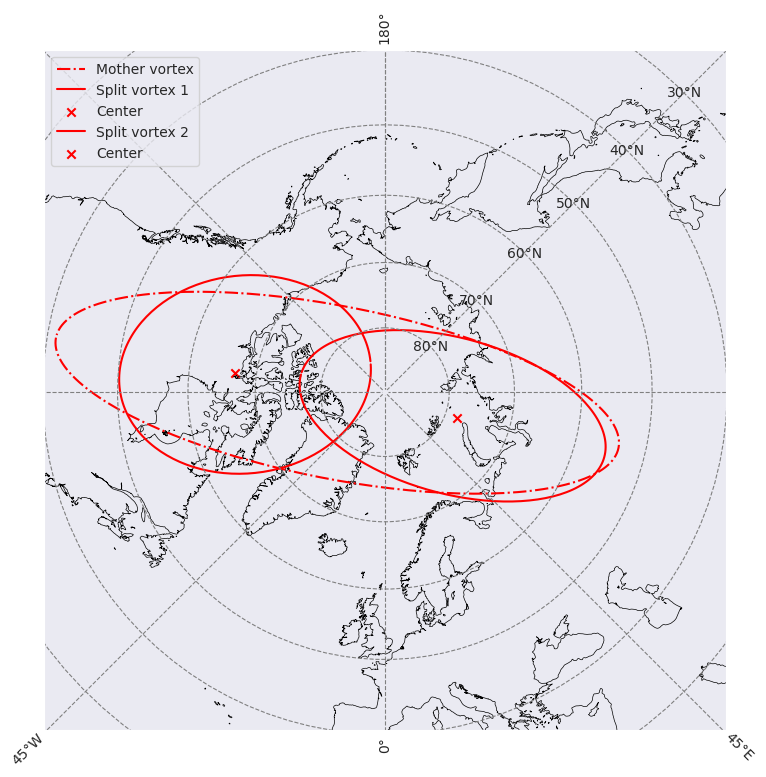

In [21]:
arctic.plot_polar_stereo(era5_all[(era5_all.string.dt.year == 2002) &
              (era5_all.ar > 3.1)])

In [22]:
era5_hannachi[(era5_hannachi.string.dt.year > 1999) &
              (era5_hannachi.y_ar_latcent == 2) &
              (era5_hannachi.latcent <60)]

string  year  month  day        area      ar  latcent  \
4653 2001-02-15 18:00:00  2001      2   15  40277000.0  1.8909   57.954   
4654 2001-02-16 18:00:00  2001      2   16  40390000.0  1.5586   56.024   
4655 2001-02-17 18:00:00  2001      2   17  39574000.0  1.8063   58.803   

      kurtosis  scaled_area  scaled_ar  scaled_latcent  scaled_kurtosis  \
4653   0.80237     0.872371   0.623244       -3.263710         0.949158   
4654   2.27610     0.881074  -0.127306       -3.579505         3.726160   
4655   2.73630     0.818226   0.432162       -3.124793         4.593331   

      filtered_area_eeof  filtered_area_ssa  y_ar_latcent  \
4653            0.109386           0.244363             2   
4654            0.144361           0.245177             2   
4655            0.128591           0.176607             2   

      y_ar_latcent_scArea  y_ar_latcent_eeofArea  y_ar_latcent_ssaArea  form  
4653                    0                      2                     1     0  
4654                    0                      2                     1     0  
4655                    0                      2                     1     0

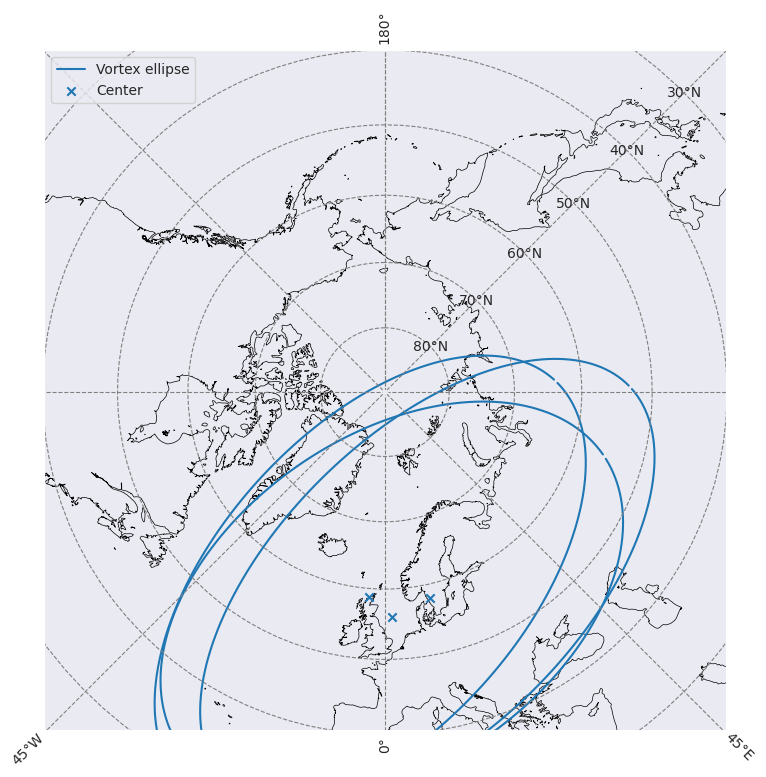

In [23]:
arctic.plot_polar_stereo(era5_all[(era5_all.string.dt.year == 2001) &
              (era5_all.latcent < 60)], mode='overlay')

## Appendix
For reasons of interest in the data the following was kept

### To Do
- [ ] fix x axis labels from Trend over the years
- [ ] fix plot hole in Seasonality over daily averages of all years

### Trend over the years
No seasonality nor actual trend could be detected when averaged over the year

### Seasonality over daily average of all years
A clear seasonality of the polar vortex can be seen in the data from the daily average over all years. It needs to be noted that the exact time of occurrence my vary from year to year.

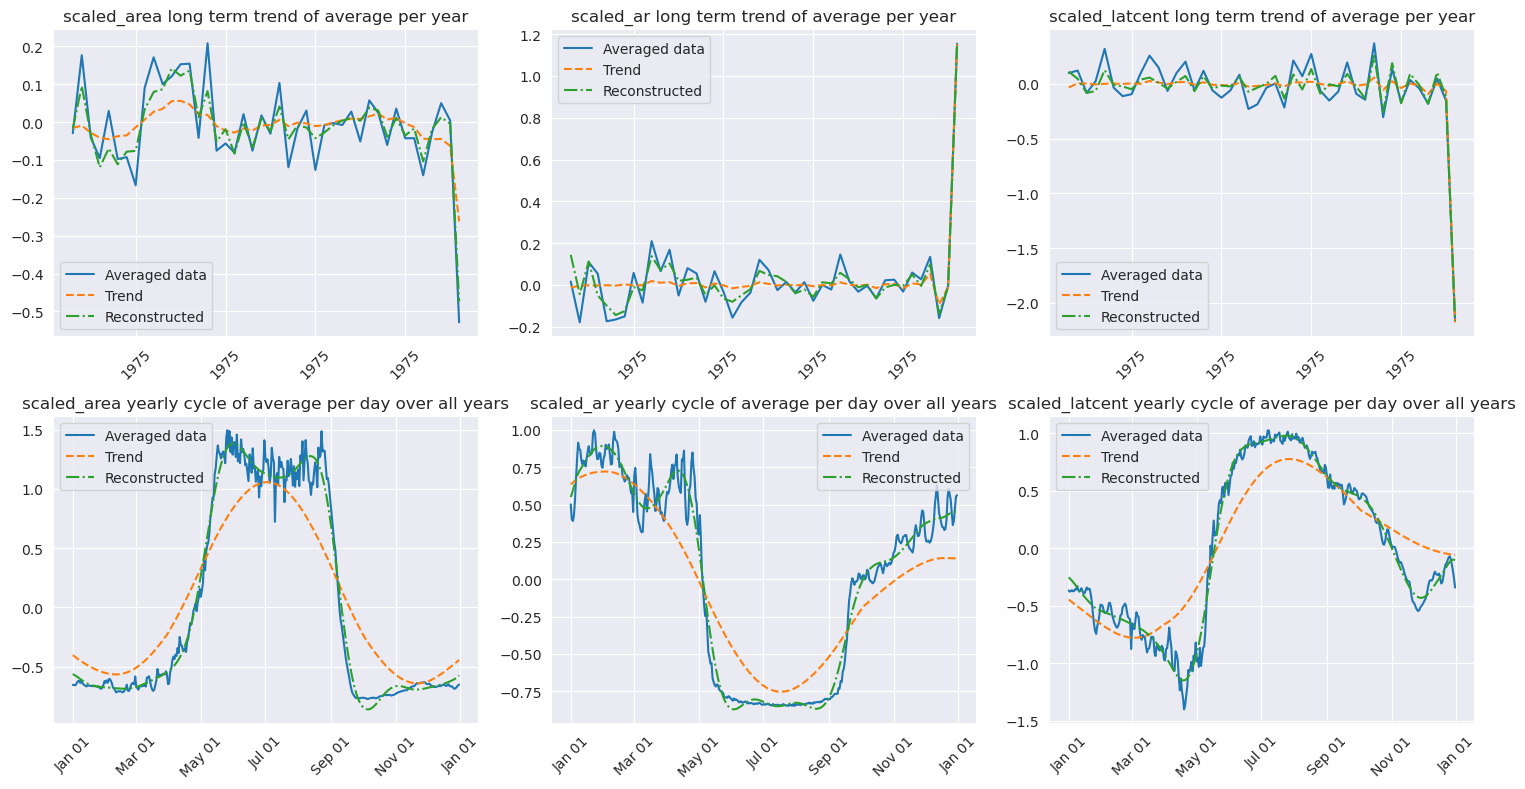

In [125]:
# Average data
avg_year = era5_all.groupby('year').mean()
avg_day_over_year = era5_all.groupby(['month', 'day']).mean()
avg_day_over_year.index = pd.to_datetime({"year": 2000,  # just a sample year, not displayed in plot
                                          "month": avg_day_over_year.index.get_level_values(0),
                                          "day": avg_day_over_year.index.get_level_values(1)})
# compute SSA
ssa_long_term = SingularSpectrumAnalysis(window_size=10)
ssa_yearly_cycle = SingularSpectrumAnalysis(window_size=90)

long_term_area = ssa_long_term.fit_transform(avg_year['scaled_area'].values.reshape(1, -1))
year_seasonality_area = ssa_yearly_cycle.fit_transform(avg_day_over_year['scaled_area'].values.reshape(1, -1))
long_term_ar = ssa_long_term.fit_transform(avg_year['scaled_ar'].values.reshape(1, -1))
year_seasonality_ar = ssa_yearly_cycle.fit_transform(avg_day_over_year['scaled_ar'].values.reshape(1, -1))
long_term_latcent = ssa_long_term.fit_transform(avg_year['scaled_latcent'].values.reshape(1, -1))
year_seasonality_latcent = ssa_yearly_cycle.fit_transform(avg_day_over_year['scaled_latcent'].values.reshape(1, -1))

# Plot SSA
plot_ssa_grid(
    data_series=[avg_year, avg_day_over_year],
    ssa_results=[[long_term_area, long_term_ar, long_term_latcent],
                 [year_seasonality_area, year_seasonality_ar, year_seasonality_latcent]],
    index_format=['%Y', '%b %d'],
    labels=['scaled_area', 'scaled_ar', 'scaled_latcent'],
    titles=['long term trend of average per year', 'yearly cycle of average per day over all years'],
    used_signals=4
)